# A Scalable Approach to Quantum Simulation via Projection-Based Embedding

This notebook will allow you to reproduce the results presented in the paper.

1. Example Molecules
2. Water Bond Dissociation
3. Cyclopentane Resource Scaling


In [1]:
from openfermion import get_sparse_operator
from scipy.sparse.linalg import eigsh
from pathlib import Path
from nbed.utils import save_ordered_xyz_file, pubchem_mol_geometry
from datetime import datetime


def ground(hamiltonian):
    sparse_ham = get_sparse_operator(hamiltonian)
    eigenvalue, _ = eigsh(sparse_ham, k=1, which="SA")
    return eigenvalue[0]


def find_and_save(mol_name):
    if Path(f"./molecular_structures/{mol_name}.xyz").exists():
        print(f"xyz file for {mol_name} already exists.\n")
        return

    geo_dict = pubchem_mol_geometry(mol_name)
    print("Molecule geometry:")
    print(geo_dict)
    save_ordered_xyz_file(mol_name, geo_dict, [0])
    print(f"xyz file for {mol_name} created.\n")


def print_results(result, active):
    print(
        f"Qubits\t\tMu:{result[active]['mu']['n_qubits']}/Huz:{result[active]['huz']['n_qubits']}/Full:{result['full']['n_qubits']}"
    )
    print(
        f"Terms\t\tMu:{result[active]['mu']['terms']}/Huz:{result[active]['huz']['terms']}/Full:{result['full']['terms']}"
    )
    print(f'DFT:\t\t{result["e_dft"]}')
    # print(f"CCSD Emb:\t{result['mu']['e_ccsd']}/{result['huz']['e_ccsd']}")
    print(f"Mu Emb:\t\t{result[active]['mu']['e_ccsd']}")
    print(f"Huz Emb:\t{result[active]['huz']['e_ccsd']}")
    print(f"CCSD:\t\t{result['full']['e_ccsd']}")
    print("\n")


def save_data(result, mol_name, localisation, force: bool):
    import os

    if not os.path.isdir("data"):
        os.mkdir("data")

    savefile = f"data/{mol_name}_{localisation}_{datetime.now()}.json"

    with open(savefile, "w") as f:
        json.dump(result, f, indent=4)
        print(f"{savefile} created.")

/Users/michaelwilliamsdelabastida/Library/Caches/pypoetry/virtualenvs/nbed-1_9TTDE1-py3.10/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Define the number of atoms to be used

In [2]:
mol_dict = {
    "acetonitrile": 2,
    "N-methylmethanamine": 2,
    "acetaldehyde": 3,
    "formamide": 3,
    "ethanamine": 3,
    "ethanol": 2,
    "fluoroethane": 2,
}

In [3]:
acetaldehyde = """
7
 
O	1.1443	0.2412	0
H	0.1478	-1.5252	-0.0007
C	0.113	-0.4226	0
C	-1.2574	0.1815	0
H	-1.7938	-0.1493	0.8924
H	-1.1865	1.2719	0.0016
H	-1.7928	-0.1468	-0.8938
"""

acetonitrile = """
6
 
N	1.2608	0	0
C	0.1006	0	0
C	-1.3613	0	0
H	-1.75	-0.8301	0.5974
H	-1.7501	-0.1022	-1.0175
H	-1.75	0.9324	0.4202
"""

ethanol = """
9
 
H	-1.1291	0.8364	0.8099
O	-1.1712	0.2997	0
C	-0.0463	-0.5665	0
H	-0.0958	-1.212	0.8819
H	-0.0952	-1.1938	-0.8946
C	1.2175	0.2668	0
H	2.105	-0.372	-0.0177
H	1.2426	0.9307	-0.8704
H	1.2616	0.9052	0.8886
"""

ethanamine = """
10
 
H	1.1926	-0.9044	0.8134
H	1.1926	-0.9044	-0.8134
N	1.2133	-0.2902	0
C	0.0295	0.5602	0
H	0.0512	1.2078	0.8824
H	0.0511	1.2078	-0.8825
C	-1.2428	-0.27	0
H	-1.2991	-0.9094	-0.8874
H	-1.2991	-0.9093	0.8875
H	-2.1202	0.3846	0
"""

N_methylmethanamine = """
10
 
N	0.0001	-0.5504	0
H	0	-1.1423	0.8302
C	-1.2001	0.2752	0
C	1.2001	0.2752	0
H	-1.2506	0.9105	0.8903
H	-2.0853	-0.3685	-0.0051
H	-1.2467	0.906	-0.8936
H	2.0853	-0.3682	-0.005
H	1.2506	0.9106	0.8903
H	1.2467	0.906	-0.8937
"""

formamide = """
6
 
O	1.128	0.2091	0
C	0.0598	-0.3882	0
H	-0.0014	-1.4883	-0.0001
N	-1.1878	0.1791	0
H	-1.3085	1.1864	0.0001
H	-2.0305	-0.3861	-0.0001
"""

fluoroethane = """
8
 
F	1.1298	0.3032	0
C	0.0745	-0.5534	0
C	-1.2043	0.2502	0
H	0.1472	-1.1828	-0.891
H	0.1471	-1.1828	0.891
H	-2.0791	-0.4057	-0.0001
H	-1.2472	0.8979	0.881
H	-1.2471	0.898	-0.8809
"""

mol_structures = {
    "acetonitrile": acetonitrile,
    "N-methylmethanamine": N_methylmethanamine,
    "acetaldehyde": acetaldehyde,
    "formamide": formamide,
    "ethanamine": ethanamine,
    "ethanol": ethanol,
    "fluoroethane": fluoroethane,
}

In [4]:
from pathlib import Path
from pyscf.gto import Mole
import nbed
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from nbed.ham_converter import HamiltonianConverter
from openfermion import count_qubits
import json
from pyscf import cc


def get_results(
    mol_name,
    active_atoms,
    localisation="pipek-mezey",
    qubits=None,
    force=True,
    unrestricted=False,
):
    print(
        f"\nGetting results for:\n\t{mol_name}\n\t{active_atoms} atoms\n\t{localisation} localisation\n"
    )
    geometry = mol_structures[mol_name]

    config = {}
    # We pass these to the driver.
    config["localization"] = localisation
    config["basis"] = "sto-3g"
    config["xc_functional"] = "b3lyp5"
    config["convergence"] = 1e-6
    config["charge"] = 0
    config["mu_level_shift"] = 1e6
    config["run_ccsd_emb"] = True
    config["run_fci_emb"] = False
    config["max_ram_memory"] = 8_000
    config["pyscf_print_level"] = 1

    result = {}
    # with open(geometry, "r") as f:
    #     result["geometry"] = f.read()
    result["geometry"] = geometry
    result.update(config)
    transform = "jordan_wigner"

    for active in active_atoms:
        print(f"Starting driver with {active} active atoms.")
        driver = NbedDriver(
            geometry=geometry, n_active_atoms=active, projector="both", **config
        )
        print("Driver finished.")
        if active == 1 or True:
            result["full"] = {}
            result["e_dft"] = driver._global_ks.e_tot
            full_builder = HamiltonianBuilder(
                driver._global_hf,
                constant_e_shift=driver._global_hf.energy_nuc(),
                transform=transform,
            )
            full_ham = full_builder.build(qubits, taper=False)
            result["full"]["qham"] = HamiltonianConverter(full_ham)._intermediate
            result["full"]["terms"] = len(full_ham.terms)
            result["full"]["n_qubits"] = count_qubits(full_ham)
            result["full"]["classical_energy"] = 0
            result["full"]["ground"] = None
            result["full"]["e_ccsd"] = (
                driver._global_ccsd.e_tot + driver._global_ccsd.ccsd_t()
            )
            print("Full system Hamiltonian built.")

        result[active] = {}
        # Mu shift result
        mu_builder = HamiltonianBuilder(
            driver._mu["scf"], driver._mu["classical_energy"], transform=transform
        )
        qham = mu_builder.build(qubits, taper=False)
        result[active]["mu"] = {}
        result[active]["mu"]["qham"] = HamiltonianConverter(qham)._intermediate
        result[active]["mu"]["terms"] = len(qham.terms)
        result[active]["mu"]["n_qubits"] = count_qubits(qham)
        result[active]["mu"]["classical_energy"] = driver._mu["classical_energy"]
        result[active]["mu"]["ground"] = None
        result[active]["mu"]["e_ccsd"] = driver._mu["e_ccsd"]
        print("Mu finished.")

        # Huzinaga result
        huz_builder = HamiltonianBuilder(
            driver._huzinaga["scf"],
            driver._huzinaga["classical_energy"],
            transform=transform,
        )
        qham = huz_builder.build(qubits, taper=False)
        result[active]["huz"] = {}
        result[active]["huz"]["qham"] = HamiltonianConverter(qham)._intermediate
        result[active]["huz"]["terms"] = len(qham.terms)
        result[active]["huz"]["n_qubits"] = count_qubits(qham)
        result[active]["huz"]["classical_energy"] = driver._huzinaga["classical_energy"]
        result[active]["huz"]["ground"] = None
        result[active]["huz"]["e_ccsd"] = driver._huzinaga["e_ccsd"]
        print("Huzinaga finished.")

        # untapered_mu = mu_builder.build(taper=False)
        # untapered_huz = huz_builder.build(taper=False)
        # untapered_full = full_builder.build(taper=False)
        # print(f"Ground diff with tapering {result['mu']['ground']-ground(untapered_mu)}/{result['huz']['ground']-ground(untapered_huz)}")
        # print(f"Untapered Qubits {count_qubits(untapered_mu)}/{count_qubits(untapered_huz)}/{count_qubits(untapered_full)}")
        # print(f"Untapered Terms {len(untapered_mu.terms)}/{len(untapered_huz.terms)}/{len(untapered_full.terms)}")

        print_results(result, active)

    result["mol_name"] = mol_name
    result["transform"] = transform
    result["qubit_limit"] = qubits

    save_data(result, mol_name, localisation, force)
    print("\n")
    return result

## Run sims

In [18]:
# Uncomment to run (it takes about 14 mins on my laptop)
for loc in ["spade", "ibo"]:
    for mol, active in mol_dict.items():
        # mol = "acetonitrile"
        # active = mol_dict[mol]
        get_results(mol, [active], force=False, localisation=loc, unrestricted=False)


Getting results for:
	acetonitrile
	[2] atoms
	spade localisation

Starting driver with 2 active atoms.


2023-12-01 22:39:18,530: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:28/Huz:28/Full:36
Terms		Mu:50847/Huz:50839/Full:136075
DFT:		-130.98422067286475
Mu Emb:		-130.3541588069316
Huz Emb:	-130.35415847427657
CCSD:		-130.49956788546763


data/acetonitrile_spade_2023-12-01 22:39:28.533654.json created.



Getting results for:
	N-methylmethanamine
	[2] atoms
	spade localisation

Starting driver with 2 active atoms.


2023-12-01 22:39:30,816: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:28/Huz:28/Full:44
Terms		Mu:55147/Huz:55143/Full:338967
DFT:		-133.38541994452146
Mu Emb:		-133.01632936332254
Huz Emb:	-133.01632925941811
CCSD:		-132.81203288742435


data/N-methylmethanamine_spade_2023-12-01 22:39:51.090652.json created.



Getting results for:
	acetaldehyde
	[3] atoms
	spade localisation

Starting driver with 3 active atoms.


2023-12-01 22:39:53,427: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:30/Huz:30/Full:38
Terms		Mu:71338/Huz:71214/Full:182702
DFT:		-151.72459708971775
Mu Emb:		-151.046428314676
Huz Emb:	-151.0464282718158
CCSD:		-151.15544413057057


data/acetaldehyde_spade_2023-12-01 22:40:07.158686.json created.



Getting results for:
	formamide
	[3] atoms
	spade localisation

Starting driver with 3 active atoms.


2023-12-01 22:40:08,882: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:26/Huz:26/Full:36
Terms		Mu:37520/Huz:37008/Full:138231
DFT:		-167.50248007935403
Mu Emb:		-166.91429636645114
Huz Emb:	-166.92990003195058
CCSD:		-166.8831648066685


data/formamide_spade_2023-12-01 22:40:18.030645.json created.



Getting results for:
	ethanamine
	[3] atoms
	spade localisation

Starting driver with 3 active atoms.


2023-12-01 22:40:20,328: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:28/Huz:28/Full:44
Terms		Mu:54823/Huz:54823/Full:329299
DFT:		-133.38678777858186
Mu Emb:		-133.02014721549503
Huz Emb:	-133.0201471732771
CCSD:		-132.81409006064456


data/ethanamine_spade_2023-12-01 22:40:40.397898.json created.



Getting results for:
	ethanol
	[2] atoms
	spade localisation

Starting driver with 2 active atoms.


2023-12-01 22:40:42,822: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:26/Huz:26/Full:42
Terms		Mu:41068/Huz:41060/Full:283020
DFT:		-152.92496376382985
Mu Emb:		-152.54687450323306
Huz Emb:	-152.55109469115155
CCSD:		-152.31579821149768


data/ethanol_spade_2023-12-01 22:40:58.853232.json created.



Getting results for:
	fluoroethane
	[2] atoms
	spade localisation

Starting driver with 2 active atoms.


2023-12-01 22:41:01,071: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:32/Huz:32/Full:40
Terms		Mu:89373/Huz:89369/Full:217385
DFT:		-176.54744199571292
Mu Emb:		-175.89917394979608
Huz Emb:	-175.8991738997491
CCSD:		-175.9105555988925


data/fluoroethane_spade_2023-12-01 22:41:18.817485.json created.



Getting results for:
	acetonitrile
	[2] atoms
	ibo localisation

Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 2.42e-09


2023-12-01 22:41:20,515: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:26/Huz:26/Full:36
Terms		Mu:34584/Huz:35588/Full:136075
DFT:		-130.98422067286475
Mu Emb:		-130.43198918886836
Huz Emb:	-130.45435716177337
CCSD:		-130.49956788546763


data/acetonitrile_ibo_2023-12-01 22:41:29.653101.json created.



Getting results for:
	N-methylmethanamine
	[2] atoms
	ibo localisation

Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 8 iter; Final gradient 9.55e-11


2023-12-01 22:41:31,804: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:22/Huz:22/Full:44
Terms		Mu:20838/Huz:20838/Full:338967
DFT:		-133.38541994452146
Mu Emb:		-133.3052150941858
Huz Emb:	-133.30521386129254
CCSD:		-132.81203288742435


data/N-methylmethanamine_ibo_2023-12-01 22:41:49.355359.json created.



Getting results for:
	acetaldehyde
	[3] atoms
	ibo localisation

Starting driver with 3 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.03e-09


2023-12-01 22:41:51,543: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:28/Huz:28/Full:38
Terms		Mu:54011/Huz:54271/Full:182702
DFT:		-151.72459708971775
Mu Emb:		-151.1292105025253
Huz Emb:	-151.13047271123685
CCSD:		-151.15544413057057


data/acetaldehyde_ibo_2023-12-01 22:42:04.109139.json created.



Getting results for:
	formamide
	[3] atoms
	ibo localisation

Starting driver with 3 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.89e-09


2023-12-01 22:42:05,655: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:24/Huz:24/Full:36
Terms		Mu:26769/Huz:26769/Full:138231
DFT:		-167.50248007935403
Mu Emb:		-167.0282518273516
Huz Emb:	-167.02825147134902
CCSD:		-166.8831648066685


data/formamide_ibo_2023-12-01 22:42:14.048331.json created.



Getting results for:
	ethanamine
	[3] atoms
	ibo localisation

Starting driver with 3 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 2.28e-09


2023-12-01 22:42:16,188: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:26/Huz:26/Full:44
Terms		Mu:40028/Huz:40340/Full:329299
DFT:		-133.38678777858186
Mu Emb:		-133.10961371237823
Huz Emb:	-133.1073132302203
CCSD:		-132.81409006064456


data/ethanamine_ibo_2023-12-01 22:42:35.094902.json created.



Getting results for:
	ethanol
	[2] atoms
	ibo localisation

Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.75e-09


2023-12-01 22:42:37,466: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:24/Huz:24/Full:42
Terms		Mu:29737/Huz:29737/Full:283020
DFT:		-152.92496376382985
Mu Emb:		-152.64657538939312
Huz Emb:	-152.64657451532588
CCSD:		-152.31579821149768


data/ethanol_ibo_2023-12-01 22:42:52.691265.json created.



Getting results for:
	fluoroethane
	[2] atoms
	ibo localisation

Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.49e-09


2023-12-01 22:42:54,823: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		Mu:26/Huz:26/Full:40
Terms		Mu:38180/Huz:38164/Full:217385
DFT:		-176.54744199571292
Mu Emb:		-176.16154938686844
Huz Emb:	-176.16154837756025
CCSD:		-175.9105555988925


data/fluoroethane_ibo_2023-12-01 22:43:08.095618.json created.




## Extract results from JSON files

In [19]:
# Extract data from the results json files

from pathlib import Path
import json

loc = "ibo"

data = {"spade": {}, "ibo": {}}
for file in Path("./data/").iterdir():
    if "ERROR" in file.name:
        continue
    loc = "spade" if "spade" in file.name else "ibo"

    print(file.name)

    with open(file, "r") as f:
        file_data = json.load(f)

    mol_name = file_data["mol_name"]
    data[loc][mol_name] = file_data
    if data[loc][mol_name]["full"].get("qham", False):
        data[loc][mol_name]["full"].pop("qham")

    for i in range(5):
        n_data = data[loc][mol_name].get(str(i), False)
        if n_data:
            if n_data["mu"].get("qham", False):
                n_data["mu"].pop("qham")
            if n_data["huz"].get("qham", False):
                n_data["huz"].pop("qham")

formamide_spade_2023-12-01 22:40:18.030645.json
ethanol_ibo_2023-12-01 22:42:52.691265.json
ethanol_spade_2023-12-01 22:40:58.853232.json
acetaldehyde_spade_2023-12-01 22:40:07.158686.json
fluoroethane_spade_2023-12-01 22:41:18.817485.json
formamide_ibo_2023-12-01 22:42:14.048331.json
acetonitrile_spade_2023-12-01 22:39:28.533654.json
acetaldehyde_ibo_2023-12-01 22:42:04.109139.json
ethanamine_ibo_2023-12-01 22:42:35.094902.json
N-methylmethanamine_spade_2023-12-01 22:39:51.090652.json
N-methylmethanamine_ibo_2023-12-01 22:41:49.355359.json
fluoroethane_ibo_2023-12-01 22:43:08.095618.json
ethanamine_spade_2023-12-01 22:40:40.397898.json
acetonitrile_ibo_2023-12-01 22:41:29.653101.json


Format the data for plotting

In [20]:
import pandas as pd


def format_data(data):
    df = pd.DataFrame(data).T
    df.head()

    threes = pd.DataFrame(df["3"].dropna().to_list(), index=df["3"].dropna().index)
    twos = pd.DataFrame(df["2"].dropna().to_list(), index=df["2"].dropna().index)
    embeddings = pd.concat([threes, twos], axis=0)
    full_vals = pd.DataFrame([v for v in df["full"].to_list()], index=df["mol_name"])
    mu_vals = pd.DataFrame([v for v in embeddings["mu"]], index=embeddings.index)
    huz_vals = pd.DataFrame([v for v in embeddings["huz"]], index=embeddings.index)

    energies = pd.concat(
        [df["e_dft"], full_vals["e_ccsd"], mu_vals["e_ccsd"], huz_vals["e_ccsd"]],
        keys=["DFT", "Full", "Mu", "Huz"],
        axis=1,
    )
    energies["dft_diffs"] = (
        (energies["DFT"] - energies["Full"]) / energies["Full"]
    ).apply(lambda x: np.log10(abs(x)))
    energies["mu_diffs"] = (
        (energies["Mu"] - energies["Full"]) / energies["Full"]
    ).apply(lambda x: np.log10(abs(x)))
    energies["huz_diffs"] = (
        (energies["Huz"] - energies["Full"]) / energies["Full"]
    ).apply(lambda x: np.log10(abs(x)))
    energies = energies.reindex(
        [
            "N-methylmethanamine",
            "acetaldehyde",
            "acetonitrile",
            "ethanamine",
            "ethanol",
            "fluoroethane",
            "formamide",
        ]
    )

    dft_diffs = energies["dft_diffs"].to_list()
    mu_diffs = energies["mu_diffs"].to_list()
    huz_diffs = energies["huz_diffs"].to_list()

    dft_diffs = np.array(dft_diffs)
    mu_diffs = np.array(mu_diffs)
    huz_diffs = np.array(huz_diffs)

    full_vals = full_vals.reindex(energies.index)
    mu_vals = mu_vals.reindex(energies.index)
    huz_vals = huz_vals.reindex(energies.index)

    mol_names = energies.index.to_list()

    return mol_names, full_vals, mu_vals, huz_vals, energies

Plot results

In [21]:
import matplotlib.pyplot as plt
import numpy as np


def plot_results(loc, mol_names, full_vals, mu_vals, huz_vals, energies):

    x = np.arange(len(mol_names))  # the label locations
    width = 0.1  # the width of the bars

    formatting = {"edgecolor": "black", "linewidth": 1}

    dft_diffs = energies["dft_diffs"].to_list()
    mu_diffs = energies["mu_diffs"].to_list()
    huz_diffs = energies["huz_diffs"].to_list()

    dft_diffs = np.array(dft_diffs)
    mu_diffs = np.array(mu_diffs)
    huz_diffs = np.array(huz_diffs)

    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 9))
    huz_es = ax1.bar(
        x - width,
        huz_diffs + 4,
        width,
        label="Huzinaga",
        color="lightgrey",
        **formatting,
    )
    mu_es = ax1.bar(
        x,
        mu_diffs + 4,
        width,
        label="$\mu$-shift",
        color="darkorange",
        hatch="///",
        **formatting,
    )
    def_es = ax1.bar(
        x + width, dft_diffs + 4, width, label="DFT", color="midnightblue", **formatting
    )

    huz_qubs = ax2.bar(
        x - width,
        huz_vals["n_qubits"],
        width,
        label="Huzinaga",
        color="lightgrey",
        **formatting,
    )
    mu_qubs = ax2.bar(
        x,
        mu_vals["n_qubits"],
        width,
        label="$\mu$-shift",
        color="darkorange",
        hatch="///",
        **formatting,
    )
    full_qubs = ax2.bar(
        x + width,
        full_vals["n_qubits"],
        width,
        label="Full system",
        color="midnightblue",
        **formatting,
    )

    huz_ts = ax3.bar(
        x - width,
        np.log10(huz_vals["terms"]),
        width,
        label="Huzinaga",
        color="lightgrey",
        **formatting,
    )
    mu_ts = ax3.bar(
        x,
        np.log10(mu_vals["terms"]),
        width,
        label="$\mu$-shift",
        color="darkorange",
        hatch="///",
        **formatting,
    )
    full_ts = ax3.bar(
        x + width,
        np.log10(full_vals["terms"]),
        width,
        label="Full system",
        color="midnightblue",
        **formatting,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_ylabel("$log_{10} (\dfrac{|\Delta E|}{H_0})$")
    ax1.set_title("(a) Molecular Ground-state Energy.")
    ax1.set_ylim(0, 2)
    ax1.set_yticks([0, 1, 2], labels=["-4", "-3", "-2"])
    ax1.set_xticks(x)
    ax1.set_xticklabels(mol_names)
    # ax1.tick_params(axis="x", rotation=50)
    # ax1.legend()

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel("Qubits")
    ax2.set_title("(b) Number of qubits in Hamiltonian.")
    ax2.set_xticks(x)
    ax2.set_xticklabels(mol_names)
    ax2.tick_params(axis="x", rotation=50)
    # ax2.legend()

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax3.set_ylabel("$log_{10}|H|$")
    ax3.set_title("(c) Number of terms in Hamiltonian.")
    ax3.set_ylim(3, 6)
    ax3.set_yticks([3, 4, 5, 6])
    ax3.set_xticks(x)
    ax3.set_xticklabels(mol_names)
    ax3.tick_params(axis="x", rotation=50)
    # ax3.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                "{}".format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    for ax in fig.get_axes():
        ax.label_outer()

    # autolabel(rects3)
    # autolabel(rects2)
    fig.suptitle(f"{loc.title()} Localisation", fontsize="xx-large")
    fig.set_size_inches(8, 8)
    fig.legend(["Huzinaga", "$\mu$-shift", "Full System"], loc="lower center", ncol=3)
    fig.tight_layout()
    plt.show()

In [22]:
def print_tables(loc, mol_names, full_vals, mu_vals, huz_vals, energies):

    print(f"{loc.title()} Localisation")
    print("\nQUBITS")
    qubits = pd.concat(
        [full_vals["n_qubits"], mu_vals["n_qubits"], huz_vals["n_qubits"]],
        keys=["Full", "Mu", "Huz"],
        axis=1,
    )
    print(qubits)

    print("\nTERMS")
    terms = pd.concat(
        [full_vals["terms"], mu_vals["terms"], huz_vals["terms"]],
        keys=["Full", "Mu", "Huz"],
        axis=1,
    )
    print(terms)

    print("\n Full System Values")
    ref_table = pd.concat(
        [energies["Full"] - energies["DFT"], qubits["Full"], terms["Full"]],
        axis=1,
        keys=["$\epsilon_{DFT}$", "Q", "|H|"],
    )
    print(ref_table)

    print("\nMolecule Results")
    mol_results = pd.concat(
        [
            energies["Full"] - energies["Huz"],
            energies["Full"] - energies["Mu"],
            qubits["Huz"],
            qubits["Mu"],
            terms["Huz"],
            terms["Mu"],
        ],
        axis=1,
        keys=[
            "$\epsilon_{huz}$",
            "$\epsilon_{\mu}$",
            "Q_huz",
            "Q_{\mu}",
            "|H_{emb}^{huz}|",
            "|H_{emb}^{\mu}|",
        ],
    )
    print(mol_results)
    print("\n\n")

Spade Localisation

QUBITS
                     Full  Mu  Huz
N-methylmethanamine    44  28   28
acetaldehyde           38  30   30
acetonitrile           36  28   28
ethanamine             44  28   28
ethanol                42  26   26
fluoroethane           40  32   32
formamide              36  26   26

TERMS
                       Full     Mu    Huz
N-methylmethanamine  338967  55147  55143
acetaldehyde         182702  71338  71214
acetonitrile         136075  50847  50839
ethanamine           329299  54823  54823
ethanol              283020  41068  41060
fluoroethane         217385  89373  89369
formamide            138231  37520  37008

 Full System Values
                    $\epsilon_{DFT}$   Q     |H|
N-methylmethanamine         0.573387  44  338967
acetaldehyde                0.569153  38  182702
acetonitrile                0.484653  36  136075
ethanamine                  0.572698  44  329299
ethanol                     0.609166  42  283020
fluoroethane                0.63688

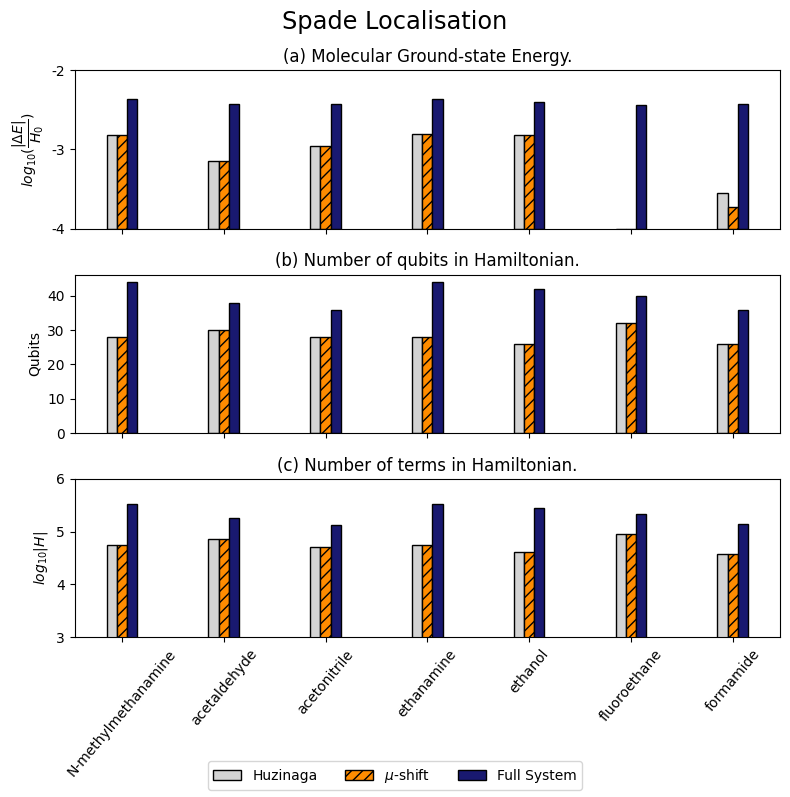

In [23]:
spade_data = format_data(data["spade"])

print_tables("spade", *spade_data)
plot_results("spade", *spade_data)

Ibo Localisation

QUBITS
                     Full  Mu  Huz
N-methylmethanamine    44  22   22
acetaldehyde           38  28   28
acetonitrile           36  26   26
ethanamine             44  26   26
ethanol                42  24   24
fluoroethane           40  26   26
formamide              36  24   24

TERMS
                       Full     Mu    Huz
N-methylmethanamine  338967  20838  20838
acetaldehyde         182702  54011  54271
acetonitrile         136075  34584  35588
ethanamine           329299  40028  40340
ethanol              283020  29737  29737
fluoroethane         217385  38180  38164
formamide            138231  26769  26769

 Full System Values
                    $\epsilon_{DFT}$   Q     |H|
N-methylmethanamine         0.573387  44  338967
acetaldehyde                0.569153  38  182702
acetonitrile                0.484653  36  136075
ethanamine                  0.572698  44  329299
ethanol                     0.609166  42  283020
fluoroethane                0.636886 

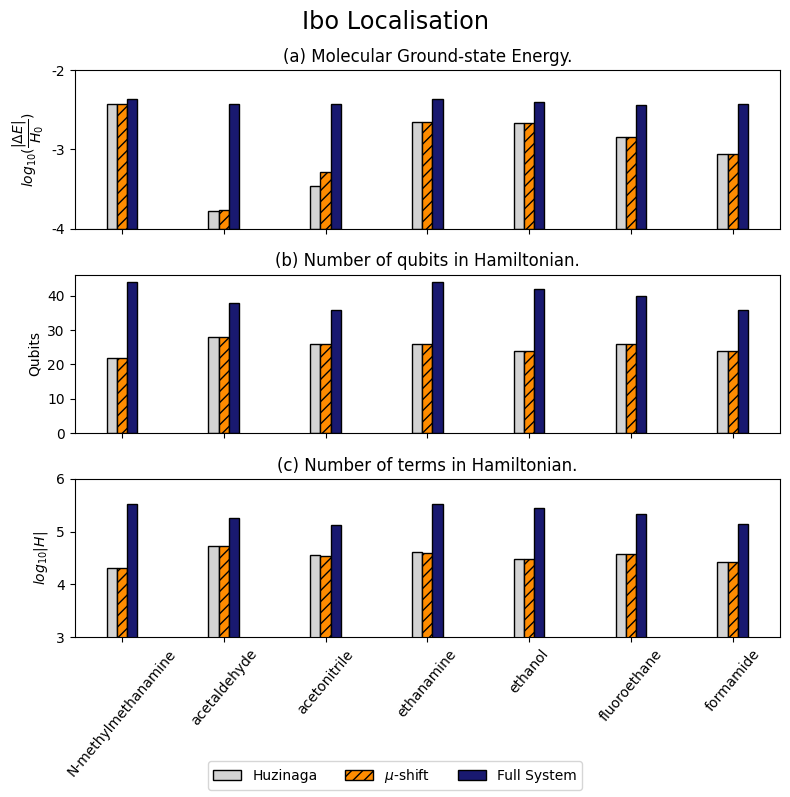

In [24]:
ibo_data = format_data(data["ibo"])

print_tables("ibo", *ibo_data)
plot_results("ibo", *ibo_data)

# Water molecule results

## Create XYZ files for stretched bond

In [27]:
"""File to generate H2O" structures."""

import numpy as np
from nbed.utils import save_ordered_xyz_file
import os


def generate_H2O_from_reference(R_length=0.8) -> str:
    """Build raw xyz string of water for a single changine O----H bond length.
    Note this changing H-bond length is kept at the TOP of xyz file.
    """

    water_xyz_list = [
        ("H", [0.7493682, 0.0000000, 0.2770822]),
        ("O", [0.0000000, 0.0000000, 0.0000000]),
        ("H", [-0.7493682, 0.0000000, 0.2770822]),
    ]
    Hyp = np.linalg.norm(water_xyz_list[0][1])
    Opp = water_xyz_list[0][1][2]
    angle = np.arcsin(Opp / Hyp)

    x_pos = np.around(R_length * np.cos(angle), 7)
    z_pos = np.around(R_length * np.sin(angle), 7)

    water_xyz_list = [
        ("H", [x_pos, 0.0000000, z_pos]),
        ("O", [0.0000000, 0.0000000, 0.0000000]),
        ("H", [-0.7493682, 0.0000000, 0.2770822]),
    ]
    struct_dict = dict(zip(range(3), water_xyz_list))

    return struct_dict


cwd = os.getcwd()
R_length_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]
for R in R_length_list:
    H2O_struct_dict = generate_H2O_from_reference(R_length=R)

    file_name = f"act_stretch_H2O_{int(R*100)}"
    save_ordered_xyz_file(
        file_name,
        struct_dict=H2O_struct_dict,
        active_atom_inds=[0, 1, 2],
        save_location=cwd,
    )

    file_name = f"act_nonstretch_H2O_{int(R*10)}"
    save_ordered_xyz_file(
        file_name,
        struct_dict=H2O_struct_dict,
        active_atom_inds=[2, 1, 0],
        save_location=cwd,
    )

Read the XYZ files

In [1]:
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from openfermion import get_sparse_operator
import scipy as sp
from openfermion.utils import count_qubits
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from nbed.mol_plot import Draw_molecule
import pandas as pd
import pickle
from nbed.ham_converter import HamiltonianConverter

current_dir = os.getcwd()
structure_dir = os.path.join(current_dir, "molecular_structures")
# order by R_length

list_files = [
    filename
    for filename in os.listdir(structure_dir)
    if filename.startswith("act_stretch_H2O")
]

all_xyz_files = sorted(
    list_files, key=lambda text: int(text.partition("H2O_")[2].partition(".xyz")[0])
)
all_xyz_files

list_file_paths = []
for xyz_filename in all_xyz_files:
    list_file_paths.append(os.path.join(structure_dir, xyz_filename))
list_file_paths

with open(list_file_paths[0], "r") as infile1:
    test_xyz = infile1.read()

print(test_xyz)

/Users/michaelwilliamsdelabastida/Library/Caches/pypoetry/virtualenvs/nbed-1_9TTDE1-py3.10/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


3
 
H	0.3751747	0.0	0.1387225
O	0.0	0.0	0.0
H	-0.7493682	0.0	0.2770822



In [28]:
driver_args = {
    "basis": "STO-3G",
    "xc_functional": "B3LYP",
    "convergence": 1e-6,
    "charge": 0,
    "mu_level_shift": 1e6,
    "run_ccsd_emb": True,
    "run_fci_emb": True,
    "max_ram_memory": 8_000,
    "pyscf_print_level": 1,
    "unit": "angstrom",
    "occupied_threshold": 0.95,
    "virtual_threshold": 0.95,
    "max_hf_cycles": 10_000,
    "max_dft_cycles": 100_000,
    "n_active_atoms": 2,
    "localization": "spade",  # ibo, spade
    "projector": "both",  #'both', 'huzinaga'
}

builder_args = {
    "transform": "jordan_wigner",
}

init_huzinaga_rhf_with_mu = True


def get_hamiltonian_from_driver(rhf_pyscf, energy_shift, qubit_transform):
    # n_qubits = 2*rhf_pyscf.mol.nao
    qham = HamiltonianBuilder(
        scf_method=rhf_pyscf,
        constant_e_shift=energy_shift,
        transform=qubit_transform,
    ).build(n_qubits=None, taper=False)
    return qham

In [39]:
def xyz_H2O_from_reference(R_length:float, active_stretch:bool) -> str:
    """Build raw xyz string of water for a single changine O----H bond length.
    Note this changing H-bond length is kept at the TOP of xyz file.
    """

    water_xyz_list = [
        ("H", [0.7493682, 0.0000000, 0.2770822]),
        ("O", [0.0000000, 0.0000000, 0.0000000]),
        ("H", [-0.7493682, 0.0000000, 0.2770822]),
    ]
    Hyp = np.linalg.norm(water_xyz_list[0][1])
    Opp = water_xyz_list[0][1][2]
    angle = np.arcsin(Opp / Hyp)

    x_pos = np.around(R_length * np.cos(angle), 7)
    z_pos = np.around(R_length * np.sin(angle), 7)

    if active_stretch:
        water_xyz = f"""3

        H {x_pos} 0.0 {z_pos}
        O 0.0000000 0.0 0.0000000
        H -0.7493682 0.0 0.2770822
        """
    else:
        water_xyz = f"""3

        H -0.7493682 0.0 0.2770822
        O 0.0000000 0.0 0.0000000
        H {x_pos} 0.0 {z_pos}
        """

    return water_xyz

In [72]:
import scipy as sp

def get_results(active_stretch: bool, localization: str) -> pd.DataFrame:
    print(f"Getting results for {active_stretch=}, {localization=}")
    df = pd.DataFrame(
        columns=[
            "global_DFT",
            "global_FCI",
            "huz emb FCI",
            "mu emb FCI",
            "global H",
            "huz_terms",
            "mu_terms",
            "global_qubits",
            "huz_qubits",
            "mu_qubits",
            "N active MOs",
            "bond_length",
            "global_H",
            "huz_embed_H",
            "mu_embed_H",
        ]
    )

    length_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]
    for R in length_list:
        print(f"Bond length {R}.")
        driver = NbedDriver(
            geometry=xyz_H2O_from_reference(R, active_stretch),
            **driver_args,
            # _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu
        )

        ## global

        global_qubit_Ham = get_hamiltonian_from_driver(
            driver._global_hf, driver._global_hf.energy_nuc(), builder_args["transform"]
        )

        global_H_sparse = get_sparse_operator(global_qubit_Ham)
        E_diag = sp.sparse.linalg.eigsh(global_H_sparse, k=1, which="SA")[0][0]

        # HUZ
        huz_classical = driver._huzinaga["classical_energy"]
        huz_qubit_Ham = get_hamiltonian_from_driver(
            driver._huzinaga["scf"],
            huz_classical,  # + driver._huzinaga["scf"].energy_nuc(),
            builder_args["transform"],
        )

        huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
        huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which="SA")[0][0]

        # mu shift
        # mu_rhf_list.append(driver._mu["e_rhf"])
        # mu_ccsd_list.append(driver._mu["e_ccsd"])
        # mu_fci_list.append(driver._mu["e_fci"])

        mu_classical = driver._mu["classical_energy"]
        mu_qubit_Ham = get_hamiltonian_from_driver(
            driver._mu["scf"],
            mu_classical,  # + driver._mu["scf"].energy_nuc(),
            builder_args["transform"],
        )

        mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
        mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which="SA")[0][0]
        np.isclose(driver._global_fci.e_tot, E_diag)


        exp_data = {
            "bond_length": R,
            "N active MOs": len(driver.localized_system.active_MO_inds),
            "global_DFT": driver._global_ks.e_tot,
            "global_FCI": E_diag,
            "global_qham": [global_qubit_Ham], 
            "huz emb FCI": huz_e_emb,
            "mu emb FCI": mu_e_emb,
            "huz_e_rhf": driver._huzinaga["e_rhf"],
            "mu_e_rhf": driver._mu["e_rhf"],
            "huz_e_ccsd": driver._huzinaga["e_ccsd"],
            "mu_e_ccsd": driver._mu["e_ccsd"],
            "huz_e_fci": driver._huzinaga["e_fci"],
            "mu_e_fci": driver._mu["e_fci"],
            "huz_terms": len(huz_qubit_Ham.terms),
            "mu_terms": len(mu_qubit_Ham.terms),
            "global_terms": len(global_qubit_Ham.terms),
            "huz_qubits": count_qubits(huz_qubit_Ham),
            "mu_qubits": count_qubits(mu_qubit_Ham),
            "global_qubits": count_qubits(global_qubit_Ham),
        }
        df = pd.concat([df, pd.DataFrame(data=exp_data)])
        del driver
    return df

In [73]:
spade_act = get_results(True, "spade")
spade_env = get_results(False, "spade")
ibo_act = get_results(True, "ibo")
ibo_env = get_results(False, "ibo")

Getting results for active_stretch=True, localization='spade'
Bond length 0.4.


2023-12-03 22:48:59,777: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 0.6.


2023-12-03 22:49:10,392: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 0.7989538439284714.


2023-12-03 22:49:20,124: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 1.


2023-12-03 22:49:27,981: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 1.2.


2023-12-03 22:49:39,383: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 1.5.


2023-12-03 22:49:50,478: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 2.


2023-12-03 22:50:01,345: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 3.


2023-12-03 22:50:14,003: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 4.


2023-12-03 22:50:39,411: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Bond length 5.


2023-12-03 22:51:42,764: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


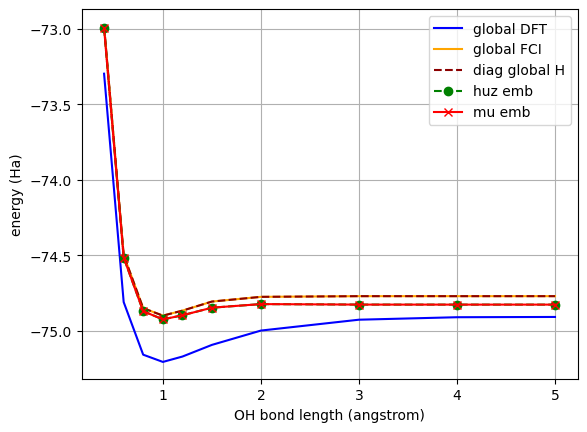

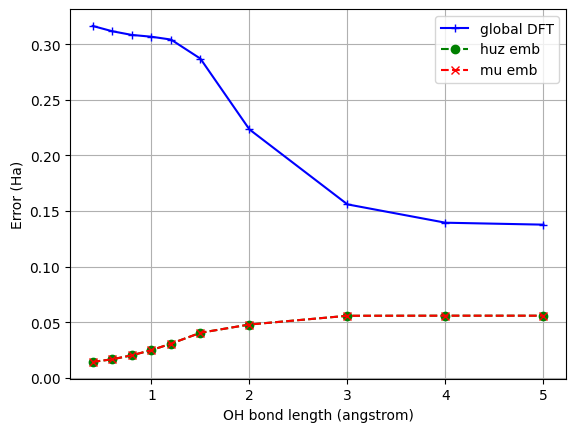

In [30]:
csv_filename = "active_OH_stretch_results_SPADE.csv"
df.to_csv(os.path.join(current_dir, csv_filename), index=False)
exp_data["bond_length"] = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]
exp_data["global_H"] = [HamiltonianConverter(H)._intermediate for H in global_H]
exp_data["huz_embed_H"] = [HamiltonianConverter(H)._intermediate for H in huz_embed_H]
exp_data["mu_embed_H"] = [HamiltonianConverter(H)._intermediate for H in mu_embed_H]

# import results
csv_filename = "active_OH_stretch_results_SPADE.csv"
df = pd.read_csv(os.path.join(current_dir, csv_filename))


In [81]:
%matplotlib inline
def plot_energy_curve(df) -> None:
    R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


    plt.plot(R_list, df["global_DFT"], label="global DFT", color="b")
    # plt.plot(R_list, global_fci_list, label="global FCI", color="orange")
    plt.plot(
        R_list, df["global_FCI"].to_numpy(), label="diag global H", linestyle="dashed", color="darkred"
    )
    plt.plot(
        R_list, df["huz emb FCI"].to_numpy(), label="huz emb", linestyle="dashed", marker="o", color="g"
    )
    plt.plot(R_list, df["mu emb FCI"].to_numpy(), label="mu emb", linestyle="-", marker="x", color="r")

    plt.xlabel("OH bond length (angstrom)")
    plt.ylabel("energy (Ha)")
    plt.grid(True)
    plt.legend()
    plt.savefig("test_energy.png", dpi=300)
    plt.show()

    %matplotlib inline

    R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


    plt.plot(
        R_list,
        abs(np.array(df["global_DFT"] - df["global_FCI"])),
        label="global DFT",
        color="b",
        marker="+",
    )
    plt.plot(
        R_list,
        abs(np.array(df["huz emb FCI"] - df["global_FCI"])),
        label="huz emb",
        linestyle="dashed",
        marker="o",
        color="g",
    )
    plt.plot(
        R_list,
        abs(np.array(df["mu emb FCI"] - df["global_FCI"])),
        label="mu emb",
        linestyle="--",
        marker="x",
        color="r",
    )

    plt.xlabel("OH bond length (angstrom)")
    plt.ylabel("Error (Ha)")
    plt.grid(True)
    plt.legend()
    plt.savefig("test_error.png", dpi=300)
    plt.show()

## Plot energy results for bond stretching

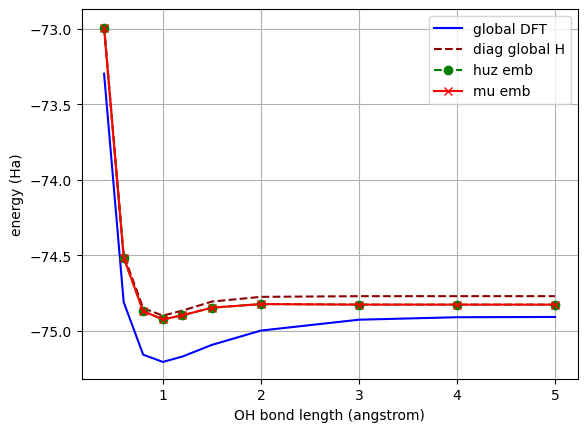

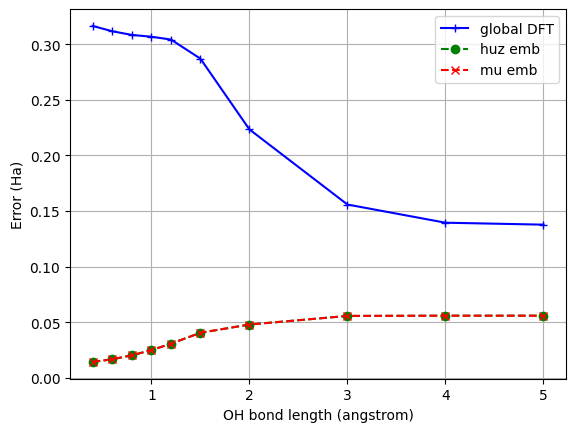

In [86]:
plot_energy_curve(spade_act)

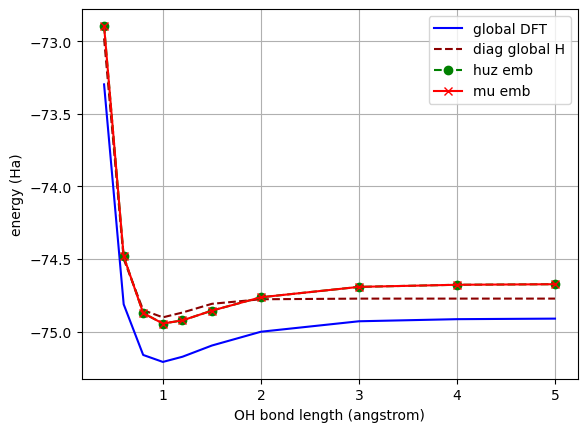

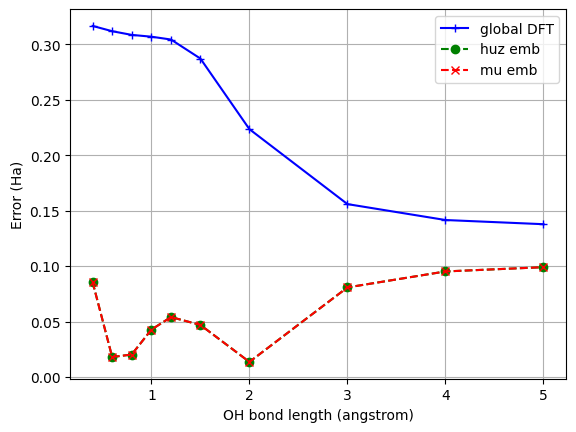

In [87]:
plot_energy_curve(spade_env)

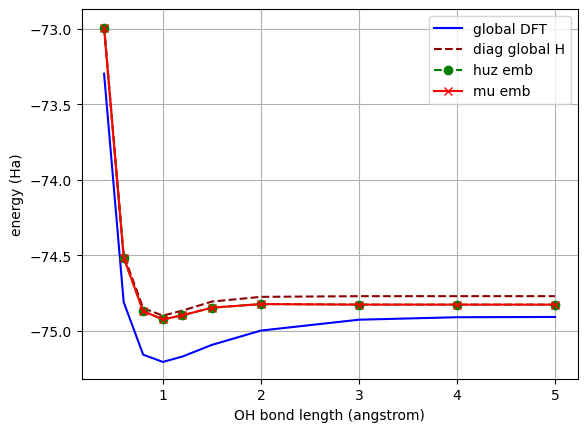

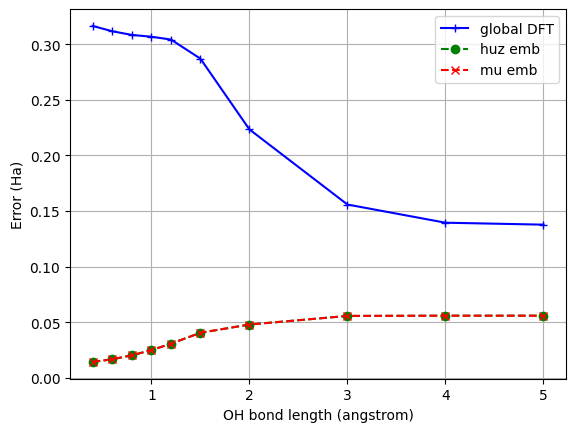

In [88]:
plot_energy_curve(ibo_act)

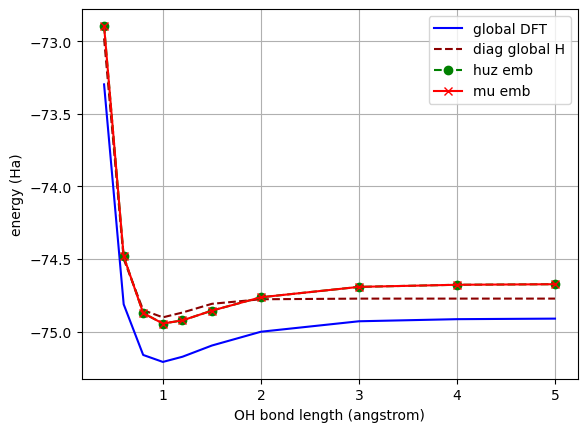

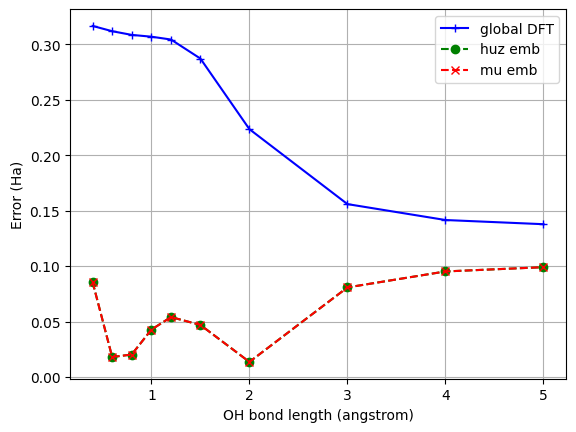

In [89]:
plot_energy_curve(ibo_env)

In [32]:
csv_filename2 = "nonactive_OH_stretch_results_SPADE.csv"
df2.to_csv(os.path.join(current_dir, csv_filename2), index=False)

exp_data2["bond_length"] = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]
exp_data2["global_H"] = [HamiltonianConverter(H)._intermediate for H in global_H2]
exp_data2["huz_embed_H"] = [HamiltonianConverter(H)._intermediate for H in huz_embed_H2]
exp_data2["mu_embed_H"] = [HamiltonianConverter(H)._intermediate for H in mu_embed_H2]
# import results
csv_filename2 = "nonactive_OH_stretch_results_SPADE.csv"
df2 = pd.read_csv(os.path.join(current_dir, csv_filename2))


In [ ]:

global_dft_list2 = np.array(df2["global DFT"])

global_fci_list2 = np.array(df2["global FCI"])
huz_H_diag_list2 = np.array(df2["huz emb FCI"])
mu_H_diag_list2 = np.array(df2["mu emb FCI"])

global_qubit_H_length_list2 = np.array(df2["global H"])
huz_qubit_H_length_list2 = np.array(df2["huz H emb"])
mu_qubit_H_length_list2 = np.array(df2["mu H emb"])

global_qubit_H_nqubits2 = np.array(df2["global n qubits"])
huz_H_nqubits2 = np.array(df2["huz n qubits"])
mu_H_nqubits2 = np.array(df2["mu n qubits"])
N_active_MOs2 = np.array(df2["N active MOs"])

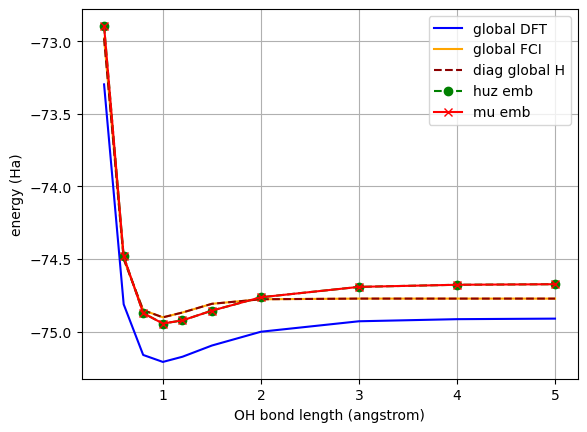

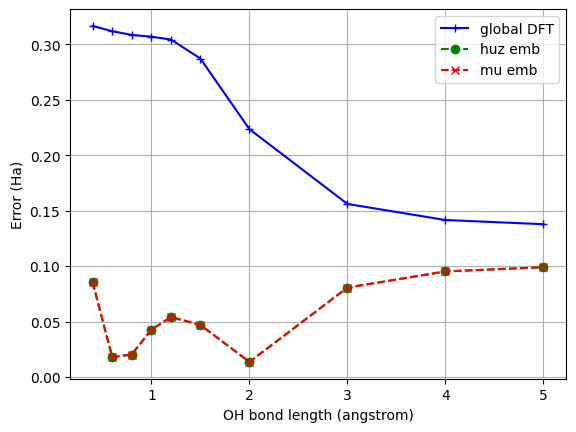

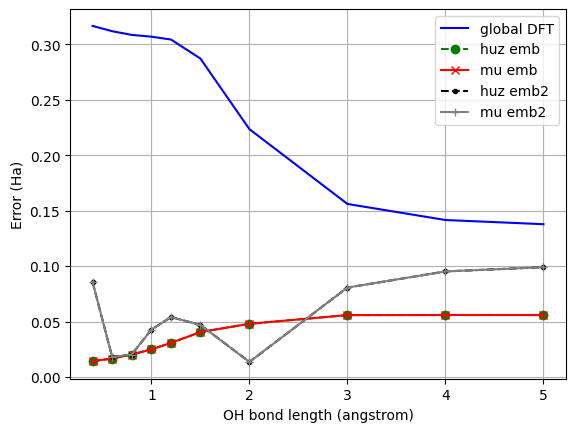

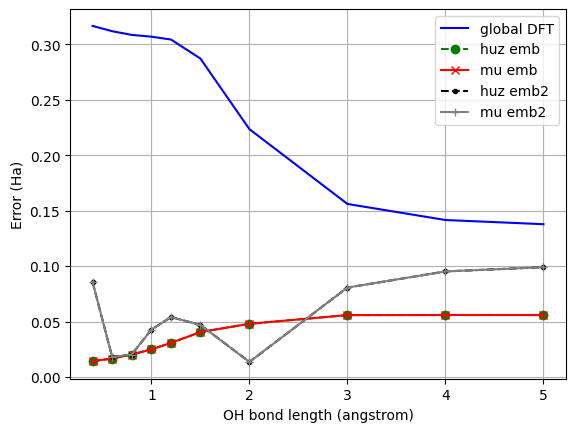

3
 
H	-0.7493682	0.0	0.2770822
O	0.0	0.0	0.0
H	0.3751747	0.0	0.1387225



3
 
H	-0.7493682	0.0	0.2770822
O	0.0	0.0	0.0
H	3.7517471	0.0	1.3872251

3
 
H	0.3751747	0.0	0.1387225
O	0.0	0.0	0.0
H	-0.7493682	0.0	0.2770822



3
 
H	3.7517471	0.0	1.3872251
O	0.0	0.0	0.0
H	-0.7493682	0.0	0.2770822



In [33]:
%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, global_dft_list2, label="global DFT", color="b")
plt.plot(R_list, global_fci_list2, label="global FCI", color="orange")
plt.plot(
    R_list, global_fci_list2, label="diag global H", linestyle="dashed", color="darkred"
)
plt.plot(
    R_list, huz_H_diag_list2, label="huz emb", linestyle="dashed", marker="o", color="g"
)
plt.plot(R_list, mu_H_diag_list2, label="mu emb", linestyle="-", marker="x", color="r")

plt.xlabel("OH bond length (angstrom)")
plt.ylabel("energy (Ha)")
plt.grid(True)
plt.legend()
plt.savefig("test_energy2.png", dpi=300)
plt.show()

%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(
    R_list,
    abs(np.array(global_dft_list2) - np.array(global_fci_list2)),
    label="global DFT",
    color="b",
    marker="+",
)
plt.plot(
    R_list,
    abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)),
    label="huz emb",
    linestyle="dashed",
    marker="o",
    color="g",
)
plt.plot(
    R_list,
    abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)),
    label="mu emb",
    linestyle="--",
    marker="x",
    color="r",
)

plt.xlabel("OH bond length (angstrom)")
plt.ylabel("Error (Ha)")
plt.grid(True)
plt.legend()
plt.savefig("test_error2.png", dpi=300)
plt.show()


%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(
    R_list,
    abs(np.array(global_dft_list2) - np.array(global_fci_list)),
    label="global DFT",
    color="b",
)
plt.plot(
    R_list,
    abs(np.array(huz_H_diag_list) - np.array(global_fci_list)),
    label="huz emb",
    linestyle="dashed",
    marker="o",
    color="g",
)
plt.plot(
    R_list,
    abs(np.array(mu_H_diag_list) - np.array(global_fci_list)),
    label="mu emb",
    linestyle="-",
    marker="x",
    color="r",
)

plt.plot(
    R_list,
    abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)),
    label="huz emb2",
    linestyle="dashed",
    marker=".",
    color="k",
)
plt.plot(
    R_list,
    abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)),
    label="mu emb2",
    linestyle="-",
    marker="+",
    color="grey",
)


plt.xlabel("OH bond length (angstrom)")
plt.ylabel("Error (Ha)")
plt.grid(True)
plt.legend()
# plt.savefig("test_error.png", dpi=300)
plt.show()

%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(
    R_list,
    abs(np.array(global_dft_list2) - np.array(global_fci_list)),
    label="global DFT",
    color="b",
)
plt.plot(
    R_list,
    abs(np.array(huz_H_diag_list) - np.array(global_fci_list)),
    label="huz emb",
    linestyle="dashed",
    marker="o",
    color="g",
)
plt.plot(
    R_list,
    abs(np.array(mu_H_diag_list) - np.array(global_fci_list)),
    label="mu emb",
    linestyle="-",
    marker="x",
    color="r",
)

plt.plot(
    R_list,
    abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)),
    label="huz emb2",
    linestyle="dashed",
    marker=".",
    color="k",
)
plt.plot(
    R_list,
    abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)),
    label="mu emb2",
    linestyle="-",
    marker="+",
    color="grey",
)


plt.xlabel("OH bond length (angstrom)")
plt.ylabel("Error (Ha)")
plt.grid(True)
plt.legend()
# plt.savefig("test_error.png", dpi=300)
plt.show()

with open(list_file_paths_nonstretch[0], "r") as infile1:
    first_xyz = infile1.read()

with open(list_file_paths_nonstretch[-2], "r") as infile2:
    last_xyz = infile2.read()

print(first_xyz)
print()
print()
print(last_xyz)

with open(list_file_paths[0], "r") as infile1:
    first_xyz = infile1.read()

with open(list_file_paths[-2], "r") as infile2:
    last_xyz = infile2.read()

print(first_xyz)
print()
print()
print(last_xyz)

array([-1.42108547e-14,  2.84217094e-14,  0.00000000e+00,  0.00000000e+00,
       -5.68434189e-14, -9.94759830e-14, -1.42108547e-13,  1.08918448e-06,
       -2.00120611e-03,  1.59619379e-05])

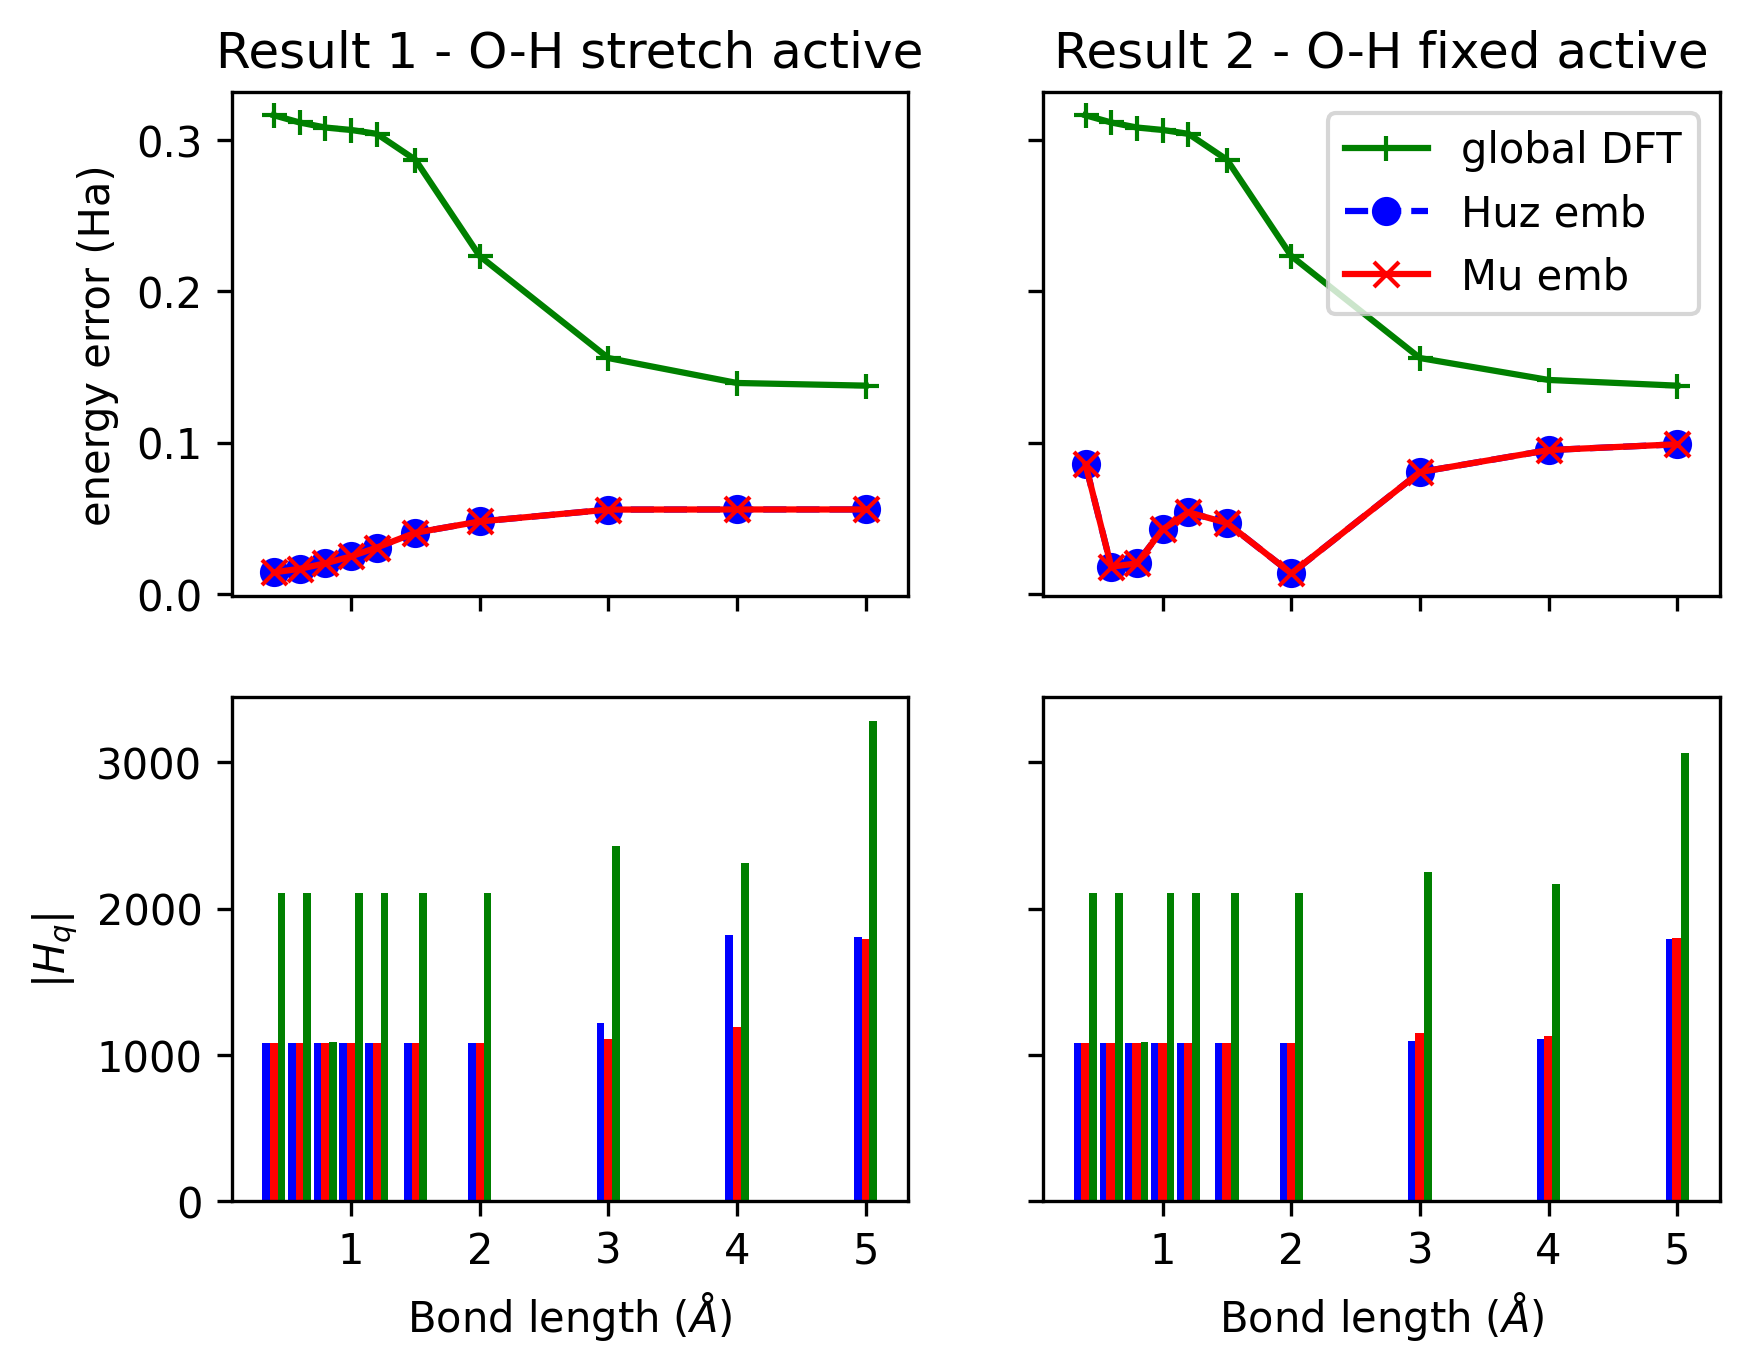

In [34]:
figure, axis = plt.subplots(2, 2, dpi=300, sharex=True)

#
axis[0, 0].xaxis.set_ticks(range(0, 6, 1))

# For first result
axis[0, 0].plot(
    R_list,
    abs(np.array(global_dft_list) - np.array(global_fci_list)),
    label="global DFT",
    color="g",
    marker="+",
)
axis[0, 0].plot(
    R_list,
    abs(np.array(huz_H_diag_list) - np.array(global_fci_list)),
    label="huz emb",
    linestyle="dashed",
    marker="o",
    color="b",
)
axis[0, 0].plot(
    R_list,
    abs(np.array(mu_H_diag_list) - np.array(global_fci_list)),
    label="mu emb",
    linestyle="-",
    marker="x",
    color="r",
)
axis[0, 0].set_ylabel("energy error (Ha)")
axis[0, 0].set_title("Result 1 - O-H stretch active")

# First result - number of terms
axis[1, 0].bar(
    np.array(R_list) - 0.06,
    huz_qubit_H_length_list,
    width=0.06,
    color="b",
    align="center",
)
axis[1, 0].bar(R_list, mu_qubit_H_length_list, width=0.06, color="r", align="center")
axis[1, 0].bar(
    np.array(R_list) + 0.06,
    global_qubit_H_length_list,
    width=0.06,
    color="g",
    align="center",
)
axis[1, 0].set_ylabel(r"$|H_{q}|$")
axis[1, 0].set_xlabel(r"Bond length ($\AA$)")
# axis[1, 0].set_title("Cosine Function")

# # 2nd result
axis[0, 1].plot(
    R_list,
    abs(np.array(global_dft_list2) - np.array(global_fci_list2)),
    label="global DFT",
    color="g",
    marker="+",
)
axis[0, 1].plot(
    R_list,
    abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)),
    label="Huz emb",
    linestyle="dashed",
    marker="o",
    color="b",
)
axis[0, 1].plot(
    R_list,
    abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)),
    label="Mu emb",
    linestyle="-",
    marker="x",
    color="r",
)
axis[0, 1].set_title("Result 2 - O-H fixed active")

# 2nd result - number of terms
axis[1, 1].bar(
    np.array(R_list) - 0.06,
    huz_qubit_H_length_list2,
    width=0.06,
    color="b",
    align="center",
)
axis[1, 1].bar(R_list, mu_qubit_H_length_list2, width=0.075, color="r", align="center")
axis[1, 1].bar(
    np.array(R_list) + 0.06,
    global_qubit_H_length_list2,
    width=0.06,
    color="g",
    align="center",
)
axis[1, 1].set_xlabel(r"Bond length ($\AA$)")

# shared y axis
axis[0, 0].get_shared_y_axes().join(axis[0, 0], axis[0, 1])
axis[1, 0].get_shared_y_axes().join(axis[1, 0], axis[1, 1])

# remove rightmost y labels
axis[0, 1].set_yticklabels([])
axis[1, 1].set_yticklabels([])

axis[0, 1].legend(loc="upper right")

figure.savefig("water_correlated_results_old.png", dpi=300)

# figure.show()

np.array(global_dft_list2) - np.array(global_dft_list)

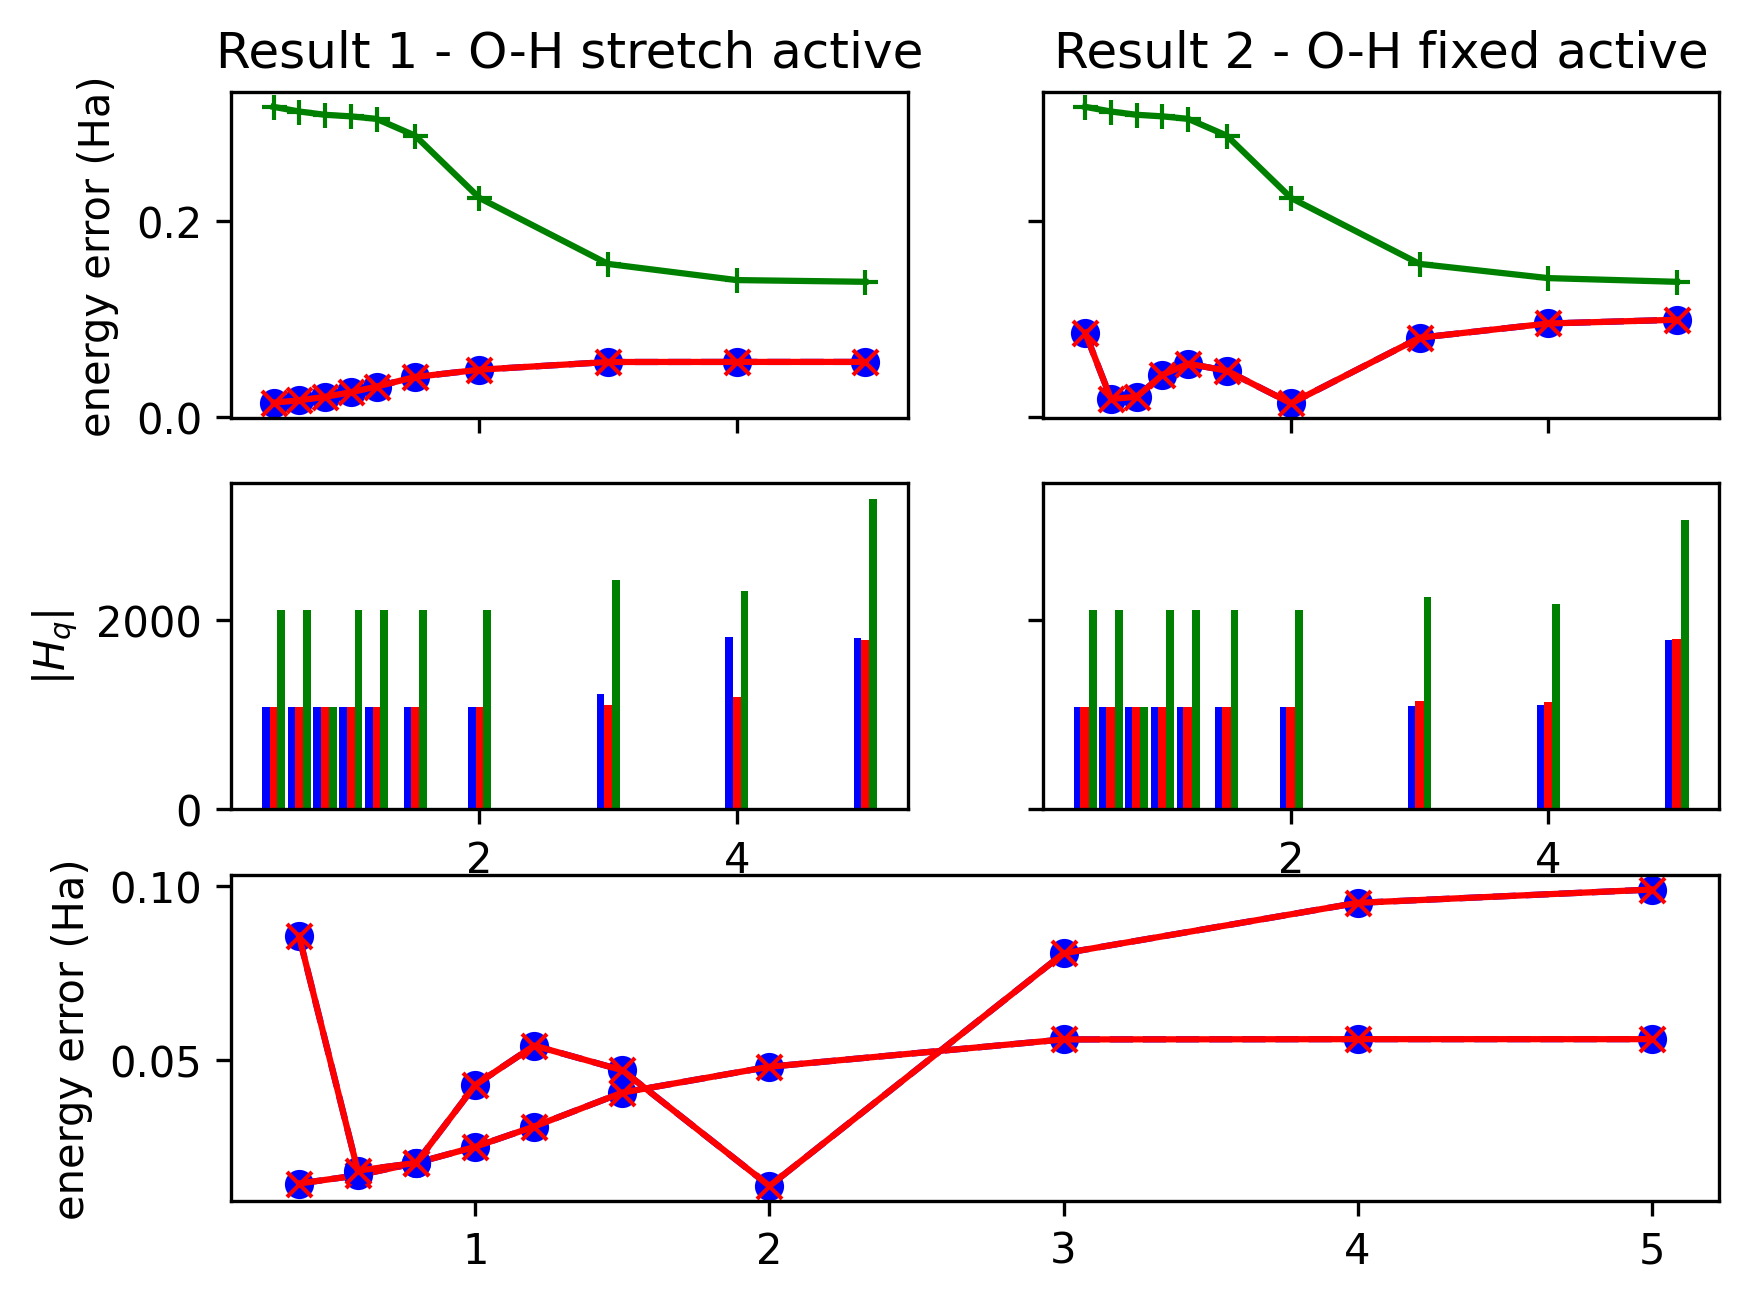

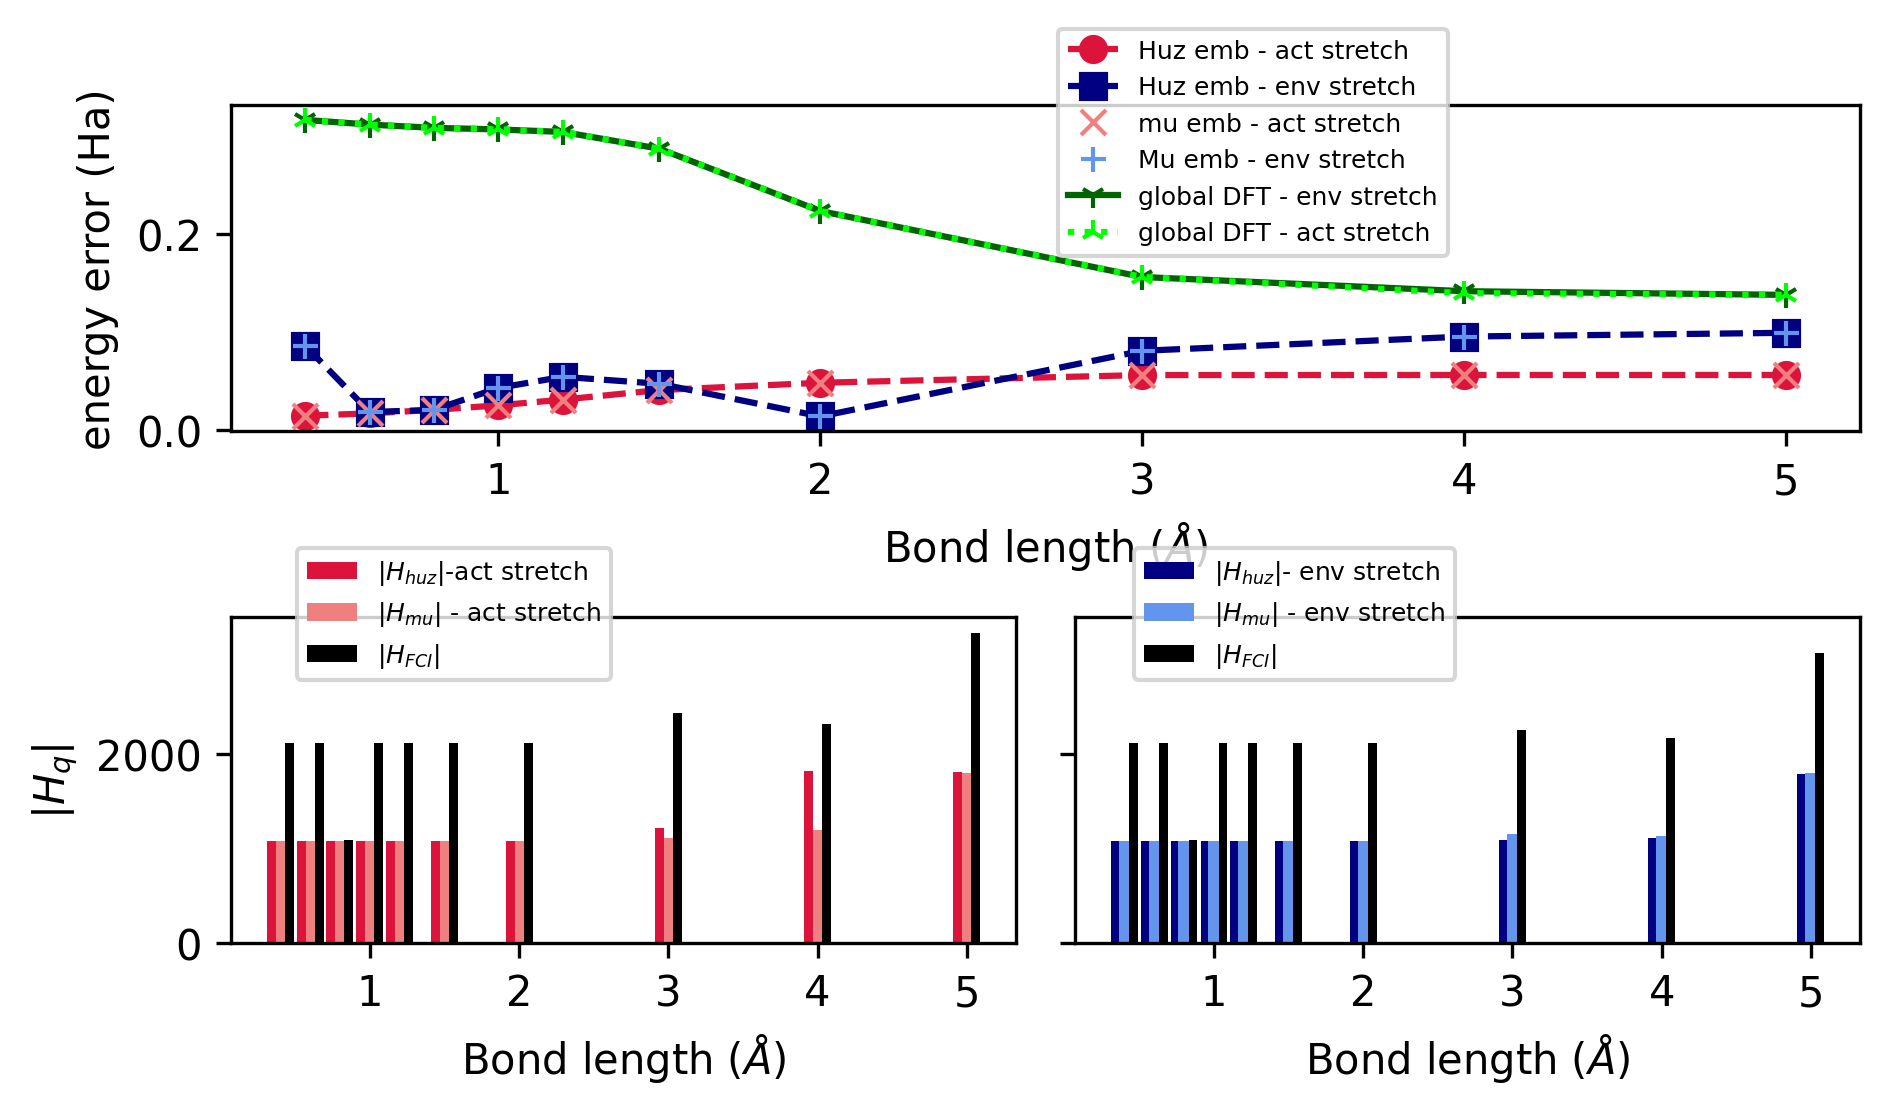

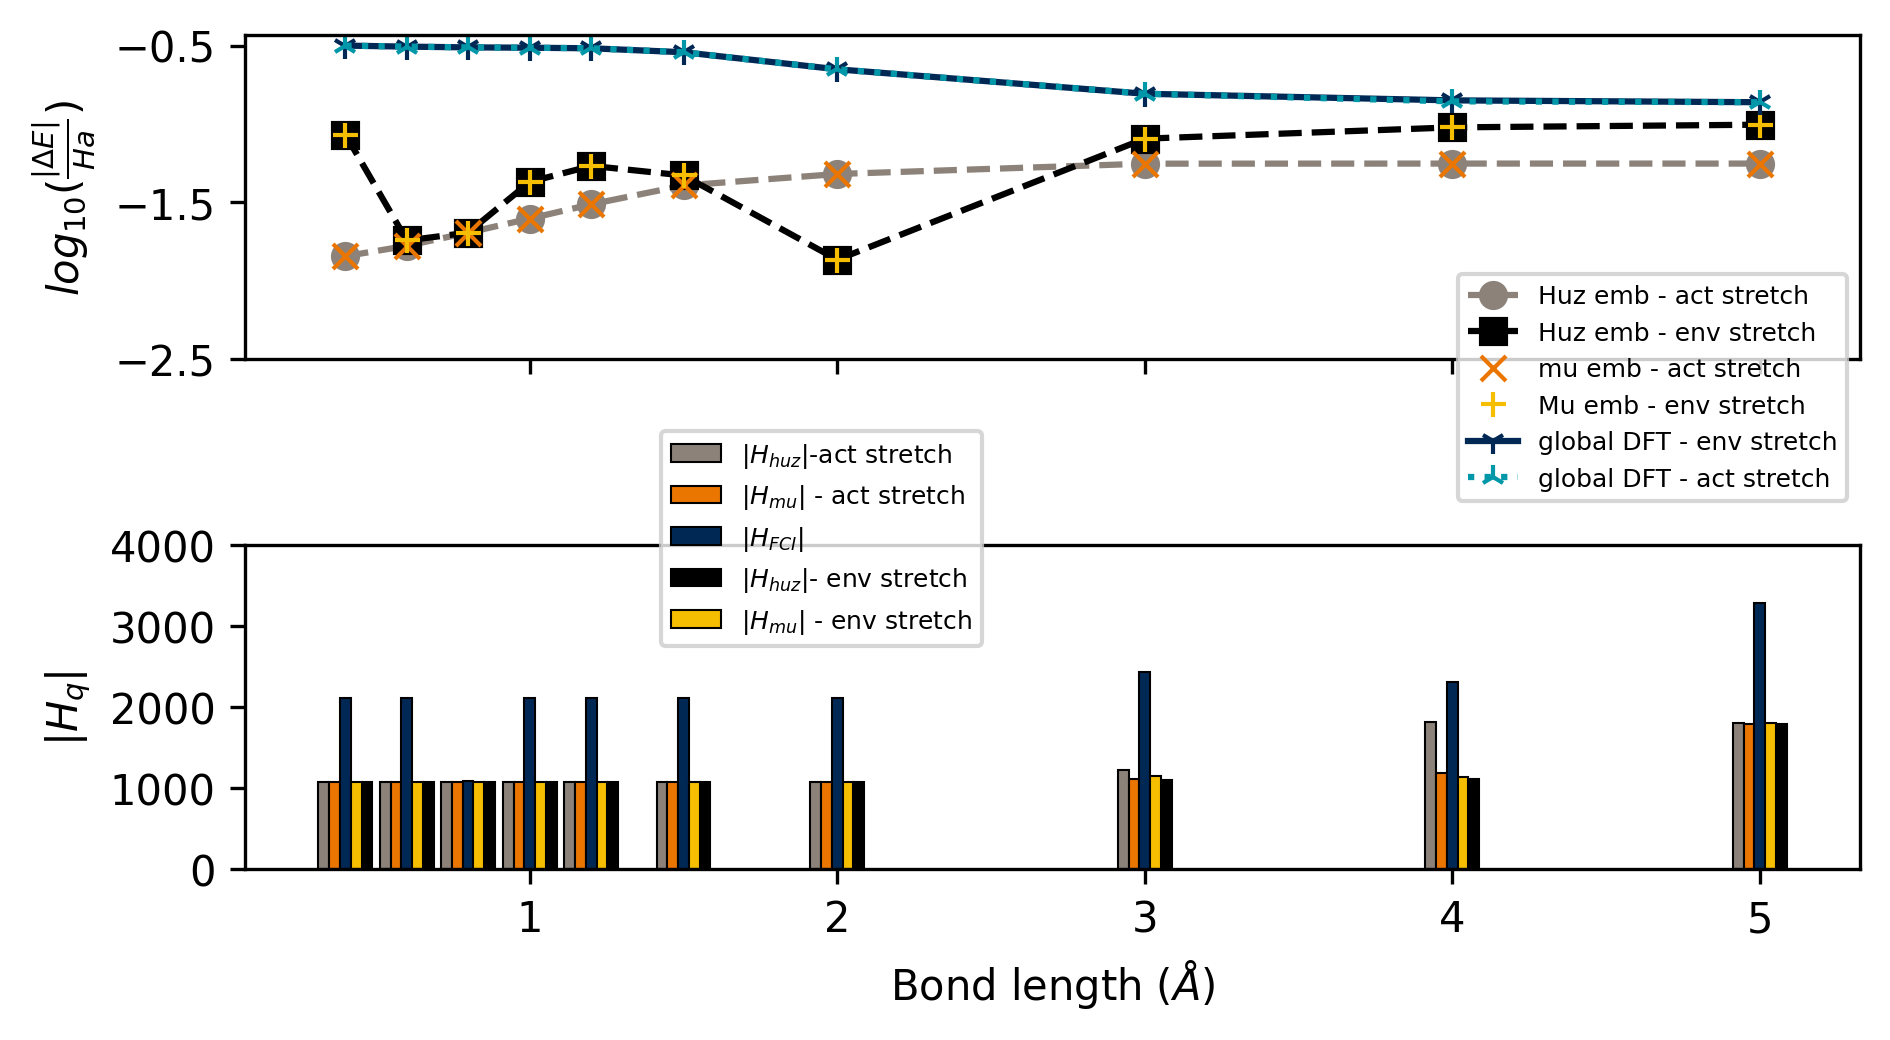

\begin{tabular}{rrrrrrrrrrr}
\toprule
OH length & error DFT & error HUZ & error mu & Hfull & Hhuz & Hmu & global n qubits & huz n qubits & mu n qubits & N active MOs \\
\midrule
0.400000 & 0.316474 & 0.014347 & 0.014347 & 2110 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0.600000 & 0.311711 & 0.016704 & 0.016705 & 2110 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
0.798954 & 0.308392 & 0.020282 & 0.020283 & 1086 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
1.000000 & 0.306763 & 0.024928 & 0.024929 & 2110 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
1.200000 & 0.304208 & 0.030768 & 0.030768 & 2110 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
1.500000 & 0.287055 & 0.040543 & 0.040543 & 2110 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
2.000000 & 0.223416 & 0.047979 & 0.047980 & 2110 & 1079 & 1079 & 14 & 12 & 12 & 4 \\
3.000000 & 0.156014 & 0.055847 & 0.055847 & 2430 & 1219 & 1107 & 14 & 12 & 12 & 4 \\
4.000000 & 0.139528 & 0.055925 & 0.055925 & 2314 & 1819 & 1191 & 14 & 12 & 12 & 4 \\
5.000000 & 0.137776 & 0.055921 & 0.055921 & 3282 & 1807 &

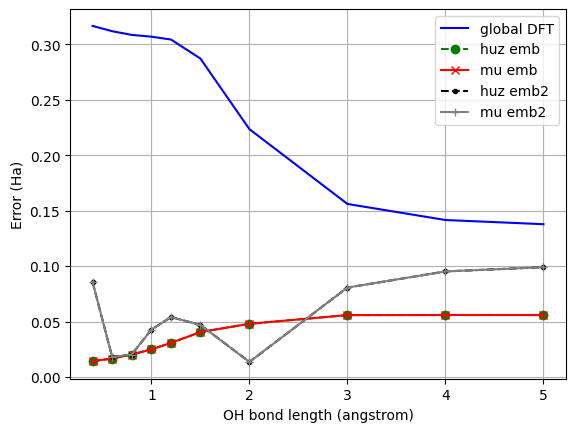

In [35]:
# geometry_path  = list_file_paths[3]
# projector = 'both'#'both', 'huzinaga'

# driver = NbedDriver(
#         geometry=geometry_path,
#         n_active_atoms=n_active_atoms,
#         basis=basis,
#         xc_functional=xc_functional,
#         projector=projector,
#         localization=localization,
#         convergence=convergence,
#         charge=charge,
#         mu_level_shift=mu_level_shift,
#         run_ccsd_emb=run_ccsd_emb,
#         run_fci_emb=run_fci_emb,
#         max_ram_memory=max_ram_memory,
#         pyscf_print_level=pyscf_print_level,
#         unit=unit,
#         occupied_threshold=occupied_threshold,
#         virtual_threshold=virtual_threshold,
#         max_hf_cycles=max_hf_cycles)
# mu_scf = driver._mu["scf"]
# huz_scf = driver._huzinaga["scf"]
# global_scf = driver._global_hf
# c_mat = mu_scf.mo_coeff
# mo_occ = mu_scf.get_occ()
# dmat = mu_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
# F =  mu_scf.get_fock(dm=dmat)

# print(np.around(c_mat.T @ F @c_mat,
#          3))
# c_mat = huz_scf.mo_coeff
# mo_occ = huz_scf.get_occ()
# dmat = huz_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
# F =  huz_scf.get_fock(dm=dmat)

# print(np.around(c_mat.T @ F @c_mat,
#          3))
fig = plt.figure(dpi=300)

gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])  # goes over both columns!

# For first result
ax1.plot(
    R_list,
    abs(np.array(global_dft_list) - np.array(global_fci_list)),
    label="global DFT",
    color="g",
    marker="+",
)
ax1.plot(
    R_list,
    abs(np.array(huz_H_diag_list) - np.array(global_fci_list)),
    label="huz emb",
    linestyle="dashed",
    marker="o",
    color="b",
)
ax1.plot(
    R_list,
    abs(np.array(mu_H_diag_list) - np.array(global_fci_list)),
    label="mu emb",
    linestyle="-",
    marker="x",
    color="r",
)
ax1.set_ylabel("energy error (Ha)")
ax1.set_title("Result 1 - O-H stretch active")

# First result - number of terms
ax3.bar(
    np.array(R_list) - 0.06,
    huz_qubit_H_length_list,
    width=0.06,
    color="b",
    align="center",
)
ax3.bar(R_list, mu_qubit_H_length_list, width=0.06, color="r", align="center")
ax3.bar(
    np.array(R_list) + 0.06,
    global_qubit_H_length_list,
    width=0.06,
    color="g",
    align="center",
)
ax3.set_ylabel(r"$|H_{q}|$")
ax3.set_xlabel(r"Bond length ($\AA$)")
# axis[1, 0].set_title("Cosine Function")

# # 2nd result
ax2.plot(
    R_list,
    abs(np.array(global_dft_list2) - np.array(global_fci_list2)),
    label="global DFT",
    color="g",
    marker="+",
)
ax2.plot(
    R_list,
    abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)),
    label="Huz emb",
    linestyle="dashed",
    marker="o",
    color="b",
)
ax2.plot(
    R_list,
    abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)),
    label="Mu emb",
    linestyle="-",
    marker="x",
    color="r",
)
ax2.set_title("Result 2 - O-H fixed active")

# 2nd result - number of terms
ax4.bar(
    np.array(R_list) - 0.06,
    huz_qubit_H_length_list2,
    width=0.06,
    color="b",
    align="center",
)
ax4.bar(R_list, mu_qubit_H_length_list2, width=0.075, color="r", align="center")
ax4.bar(
    np.array(R_list) + 0.06,
    global_qubit_H_length_list2,
    width=0.06,
    color="g",
    align="center",
)
ax4.set_xlabel(r"Bond length ($\AA$)")

# shared y axis
ax1.get_shared_y_axes().join(ax1, ax2)
ax3.get_shared_y_axes().join(ax3, ax4)

# shared x axis
ax1.get_shared_x_axes().join(ax1, ax3)
ax2.get_shared_x_axes().join(ax2, ax4)


# remove rightmost y labels
ax2.set_yticklabels([])
ax4.set_yticklabels([])

# remove rightmost x labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax5.plot(
    R_list,
    abs(np.array(huz_H_diag_list) - np.array(global_fci_list)),
    label="huz emb",
    linestyle="dashed",
    marker="o",
    color="b",
)
ax5.plot(
    R_list,
    abs(np.array(mu_H_diag_list) - np.array(global_fci_list)),
    label="mu emb",
    linestyle="-",
    marker="x",
    color="r",
)
ax5.plot(
    R_list,
    abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)),
    label="Huz emb",
    linestyle="dashed",
    marker="o",
    color="b",
)
ax5.plot(
    R_list,
    abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)),
    label="Mu emb",
    linestyle="-",
    marker="x",
    color="r",
)

# ax5.plot(R_list,abs(np.array(global_dft_list2) - np.array(global_fci_list2)), label='global DFT', color='g', marker='+')
# ax5.plot(R_list,abs(np.array(global_dft_list) - np.array(global_fci_list)), label='global DFT', color='r', marker='x', linestyle='--')

ax5.set_ylabel("energy error (Ha)")

fig = plt.figure(dpi=300)

gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, :])  # goes over both columns!
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


ax1.plot(
    R_list,
    abs(np.array(huz_H_diag_list) - np.array(global_fci_list)),
    label="Huz emb - act stretch",
    marker="o",
    color="crimson",
    linestyle="dashed",
)
ax1.plot(
    R_list,
    abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)),
    label="Huz emb - env stretch",
    marker="s",
    color="navy",
    linestyle="dashed",
)
ax1.plot(
    R_list,
    abs(np.array(mu_H_diag_list) - np.array(global_fci_list)),
    label="mu emb - act stretch",
    marker="x",
    color="lightcoral",
    linestyle="",
)
ax1.plot(
    R_list,
    abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)),
    label="Mu emb - env stretch",
    marker="+",
    color="cornflowerblue",
    linestyle="",
)

ax1.plot(
    R_list,
    abs(np.array(global_dft_list2) - np.array(global_fci_list2)),
    label="global DFT - env stretch",
    color="darkgreen",
    marker="1",
)
ax1.plot(
    R_list,
    abs(np.array(global_dft_list) - np.array(global_fci_list)),
    label="global DFT - act stretch",
    color="lime",
    marker="2",
    linestyle="dotted",
)


# ax1.legend(loc="upper right", fontsize =5)

ax1.set_ylabel("energy error (Ha)")
ax1.set_xlabel(r"Bond length ($\AA$)")


# First result - number of terms
ax2.bar(
    np.array(R_list) - 0.06,
    huz_qubit_H_length_list,
    width=0.06,
    color="crimson",
    align="center",
    label="$|H_{huz}|$-act stretch",
)
ax2.bar(
    R_list,
    mu_qubit_H_length_list,
    width=0.06,
    color="lightcoral",
    align="center",
    label="$|H_{mu}|$ - act stretch",
)
ax2.bar(
    np.array(R_list) + 0.06,
    global_qubit_H_length_list,
    width=0.06,
    color="k",
    align="center",
    label="$|H_{FCI}|$",
)
ax2.set_ylabel(r"$|H_{q}|$")
ax2.set_xlabel(r"Bond length ($\AA$)")
# axis[1, 0].set_title("Cosine Function")

# 2nd result - number of terms
ax3.bar(
    np.array(R_list) - 0.06,
    huz_qubit_H_length_list2,
    width=0.06,
    color="navy",
    align="center",
    label="$|H_{huz}|$- env stretch",
)
ax3.bar(
    R_list,
    mu_qubit_H_length_list2,
    width=0.075,
    color="cornflowerblue",
    align="center",
    label="$|H_{mu}|$ - env stretch",
)
ax3.bar(
    np.array(R_list) + 0.06,
    global_qubit_H_length_list2,
    width=0.06,
    color="k",
    align="center",
    label="$|H_{FCI}|$",
)
ax3.set_xlabel(r"Bond length ($\AA$)")

# shared y axis
ax2.get_shared_y_axes().join(ax2, ax3)

# remove rightmost y labels
ax3.set_yticklabels([])

plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), fontsize=6)
ax2.legend(bbox_to_anchor=(0.0, 0.75, 0.5, 0.5), fontsize=6)
ax3.legend(bbox_to_anchor=(0.0, 0.75, 0.5, 0.5), fontsize=6)

fig.savefig("water_correlated_results_new.png", bbox_inches="tight")
plt.show()


fig = plt.figure(dpi=300)

gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, :])  # goes over both columns!
ax2 = fig.add_subplot(gs[1, :])
# ax3 = fig.add_subplot(gs[1,1])

# colour_stone = '#C0BDB0' #'#D6D2C4'
# colour_dark_brown = '#4E3629'

# colour_stone = '#500778'
# colour_dark_brown = '#AC145A'

colour_stone = "#8C8279"
colour_dark_brown = "k"  #'#47423e'

colour_midblue = "#002855"
colour_brightblue = "#0097A9"

colour_orange = "#EA7600"
colour_dark_yellow = "#F6BE00"

FCI_colour = "#002855"


ax1.plot(
    R_list,
    np.log10(abs(np.array(huz_H_diag_list) - np.array(global_fci_list))),
    label="Huz emb - act stretch",
    marker="o",
    color=colour_stone,
    linestyle="dashed",
)
ax1.plot(
    R_list,
    np.log10(abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2))),
    label="Huz emb - env stretch",
    marker="s",
    color=colour_dark_brown,
    linestyle="dashed",
)
ax1.plot(
    R_list,
    np.log10(abs(np.array(mu_H_diag_list) - np.array(global_fci_list))),
    label="mu emb - act stretch",
    marker="x",
    color=colour_orange,
    linestyle="",
)
ax1.plot(
    R_list,
    np.log10(abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2))),
    label="Mu emb - env stretch",
    marker="+",
    color=colour_dark_yellow,
    linestyle="",
)

ax1.plot(
    R_list,
    np.log10(abs(np.array(global_dft_list2) - np.array(global_fci_list2))),
    label="global DFT - env stretch",
    color=colour_midblue,
    marker="1",
)
ax1.plot(
    R_list,
    np.log10(abs(np.array(global_dft_list) - np.array(global_fci_list))),
    label="global DFT - act stretch",
    color=colour_brightblue,
    marker="2",
    linestyle="dotted",
)


# ax1.legend(loc="upper right", fontsize =5)

# ax1.set_ylabel('energy error (Ha)')
ax1.set_ylabel(r"$log_{10}(\frac{|\Delta E|}{Ha})$")
# ax1.set_xlabel(r'Bond length ($\AA$)')
ax1.set_xticklabels([])


# First result - number of terms
wid = 0.035

ax2.bar(
    np.array(R_list) - 2 * wid,
    huz_qubit_H_length_list,
    width=wid,
    color=colour_stone,
    align="center",
    label="$|H_{huz}|$-act stretch",
    edgecolor="k",
    linewidth=0.5,
)
ax2.bar(
    np.array(R_list) - wid,
    mu_qubit_H_length_list,
    width=wid,
    color=colour_orange,
    align="center",
    label="$|H_{mu}|$ - act stretch",
    edgecolor="k",
    linewidth=0.5,
)
ax2.bar(
    np.array(R_list),
    global_qubit_H_length_list,
    width=wid,
    color=FCI_colour,
    align="center",
    label="$|H_{FCI}|$",
    edgecolor="k",
    linewidth=0.5,
)
ax2.set_ylabel(r"$|H_{q}|$")
ax2.set_xlabel(r"Bond length ($\AA$)")

ax2.bar(
    np.array(R_list) + 2 * wid,
    huz_qubit_H_length_list2,
    width=wid,
    color=colour_dark_brown,
    align="center",
    label="$|H_{huz}|$- env stretch",
    edgecolor="k",
    linewidth=0.5,
)
ax2.bar(
    np.array(R_list) + wid,
    mu_qubit_H_length_list2,
    width=wid,
    color=colour_dark_yellow,
    align="center",
    label="$|H_{mu}|$ - env stretch",
    edgecolor="k",
    linewidth=0.5,
)
ax2.set_xlabel(r"Bond length ($\AA$)")

# shared x axis
ax1.get_shared_x_axes().join(ax1, ax2)

# set axis limits
# ax1.yaxis.set_ticks(np.arange(0, 0.4, 0.1))
ax1.yaxis.set_ticks(np.arange(-2.5, 0, 1))
ax2.yaxis.set_ticks(np.arange(0, 5000, 1000))

plt.tight_layout()
# ax1.legend(bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), fontsize=6)
ax1.legend(bbox_to_anchor=(0.5, -0.2, 0.5, 0.5), fontsize=6)
ax2.legend(bbox_to_anchor=(0.25, 0.65, 0.5, 0.5), fontsize=6)

fig.savefig("water_correlated_results_SPADE.png", bbox_inches="tight")
plt.show()

np.log10(2)


R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]

error_DFT = abs(np.array(global_dft_list) - np.array(global_fci_list))
error_HUZ = abs(np.array(huz_H_diag_list) - np.array(global_fci_list))
error_MU = abs(np.array(mu_H_diag_list) - np.array(global_fci_list))
plot_data_1 = {
    "OH length": R_list,
    "error DFT": error_DFT,
    "error HUZ": error_HUZ,
    "error mu": error_MU,
    "Hfull": global_qubit_H_length_list,
    "Hhuz": huz_qubit_H_length_list,
    "Hmu": mu_qubit_H_length_list,
    "global n qubits": global_qubit_H_nqubits,
    "huz n qubits": huz_H_nqubits,
    "mu n qubits": mu_H_nqubits,
    "N active MOs": N_active_MOs,
}

df_data1 = pd.DataFrame(data=plot_data_1)
print(df_data1.to_latex(index=False))

error_DFT2 = abs(np.array(global_dft_list2) - np.array(global_fci_list2))
error_HUZ2 = abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2))
error_MU2 = abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2))


plot_data_2 = {
    "OH length": R_list,
    "error DFT": error_DFT2,
    "error HUZ": error_HUZ2,
    "error mu": error_MU2,
    "Hfull": global_qubit_H_length_list2,
    "Hhuz": huz_qubit_H_length_list2,
    "Hmu": mu_qubit_H_length_list2,
    "global n qubits": global_qubit_H_nqubits2,
    "huz n qubits": huz_H_nqubits2,
    "mu n qubits": mu_H_nqubits2,
    "N active MOs": N_active_MOs2,
}

df_data2 = pd.DataFrame(data=plot_data_2)
print(df_data2.to_latex(index=False))

##
# pickle_dir = os.path.join(current_dir, "pickle_output")
# os.makedirs(pickle_dir)

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(
    R_list,
    abs(np.array(global_dft_list2) - np.array(global_fci_list)),
    label="global DFT",
    color="b",
)
plt.plot(
    R_list,
    abs(np.array(huz_H_diag_list) - np.array(global_fci_list)),
    label="huz emb",
    linestyle="dashed",
    marker="o",
    color="g",
)
plt.plot(
    R_list,
    abs(np.array(mu_H_diag_list) - np.array(global_fci_list)),
    label="mu emb",
    linestyle="-",
    marker="x",
    color="r",
)

plt.plot(
    R_list,
    abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)),
    label="huz emb2",
    linestyle="dashed",
    marker=".",
    color="k",
)
plt.plot(
    R_list,
    abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)),
    label="mu emb2",
    linestyle="-",
    marker="+",
    color="grey",
)


plt.xlabel("OH bond length (angstrom)")
plt.ylabel("Error (Ha)")
plt.grid(True)
plt.legend()
# plt.savefig("test_error.png", dpi=300)
plt.show()

##
pickle_dir = os.path.join(current_dir, "pickle_output")
if not os.path.exists(pickle_dir):
    os.makedirs(pickle_dir)

fname = "active_stretch"
fpath = os.path.join(pickle_dir, fname + ".pickle")
with open(fpath, "wb") as fp:
    pickle.dump(exp_data, fp)

fname2 = "enviro_stretch"
fpath2 = os.path.join(pickle_dir, fname2 + ".pickle")
with open(fpath2, "wb") as fp:
    pickle.dump(exp_data2, fp)